# Refine Feature Groups into Final Bins

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#from jax.config import config
#config.update("jax_enable_x64", True)

In [3]:
import datetime
import yaml
import itertools
from pathlib import Path

In [4]:
from tomo_challenge import load_redshift

Found classifier Random
You need to install the zotbin package:
  pip install git+https://github.com/dkirkby/zotbin.git
Found classifier ZotBin
Found classifier RandomForest
Found classifier IBandOnly


In [4]:
import jax
import jax.numpy as jnp
from jax.experimental import stax,optimizers

In [5]:
from zotbin.group import load_groups
from zotbin.reweight import reweighted_metrics
from zotbin.binned import load_binned
from zotbin.optimize import *

In [6]:
init_data = load_binned('binned_3_80.npz')

## Framework for Running Studies

In [7]:
def save_study(kw, results, outpath):
    """Save results from a study.
    """
    nbin = kw['nbin']
    init_data = kw['init_data']
    best_scores, weights, dndz_bin, all_scores = results
    np.savez(outpath / f'dndz-{nbin}.npz', dndz=dndz_bin, weights=weights, zedges=init_data[0])
    for scores in all_scores:
        plt.plot(scores, 'r-', alpha=0.3)
    plt.xlabel('Optimization step')
    plt.ylabel(kw.get('metric', 'Score'))
    plt.savefig(outpath / f'training-{nbin}.png')
    plt.show()
    plot_dndz(dndz_bin, init_data[0])
    plt.savefig(outpath / f'dndz-{nbin}.png')
    plt.show()
    with open(outpath / f'scores-{nbin}.yaml', 'w') as f:
        yaml.dump(best_scores, f)

In [8]:
def study_complete(nbin, outpath):
    """Check if a study has already been completed and saved.
    """
    return (outpath / f'scores-{nbin}.yaml').exists()

In [9]:
def run_study(path, func, rerun=[]):
    """Run a study configured by a yaml file.
    """
    path = Path(path)
    with open(path / 'config.yaml') as f:
        config = yaml.safe_load(f)
    nstudy = len(config['nbin'])
    argsiter = []
    argnames = config.keys()
    for arg in argnames:
        if not isinstance(config[arg], list):
            argsiter.append(itertools.repeat(config[arg]))
        elif len(config[arg]) != nstudy:
            print(f'Expected 1 or {nstudy} values for {arg}.')
            return
        else:
            argsiter.append(iter(config[arg]))
    for argvalues in zip(*argsiter):
        kw = dict(zip(argnames, argvalues))
        nbin = kw['nbin']
        outpath = path / f'nbin-{nbin}'
        if not outpath.exists():
            outpath.mkdir()          
        if (not rerun == 'all') and (nbin not in rerun) and study_complete(nbin, outpath):
            # Assume that this job has already run successfully.
            print(f'Skipping already completed job for nbin={nbin}')
            continue
        # Run the optimization for this nbin.
        start = datetime.datetime.now()
        print(f'Starting job at {start} with {kw}')
        results = func(**kw)
        elapsed = datetime.datetime.now() - start
        print(f'Job ran for {elapsed}')
        # Save the results to outpath.
        kw['init_data'] = init_data
        save_study(kw, results, outpath)

## Optimize using redshifts directly

Calculate the normalized dndz for the DC2 and Buzzard datasets using the downsampled binning:

In [11]:
zds = np.asarray(init_data[0])

In [12]:
zdc2 = load_redshift('/media/data2/tomo_challenge_data/ugrizy/training.hdf5')
zbuz = load_redshift('/media/data2/tomo_challenge_data/ugrizy_buzzard/training.hdf5')

In [13]:
dndz_dc2, _ = np.histogram(zdc2, zds)
dndz_dc2 = dndz_dc2 / dndz_dc2.sum()

In [14]:
dndz_buz, _ = np.histogram(zbuz, zds)
dndz_buz = dndz_buz / dndz_buz.sum()

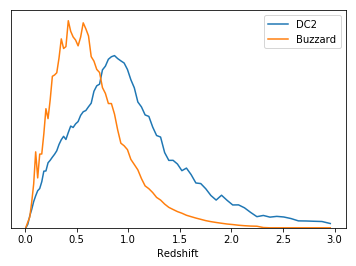

In [15]:
zc = 0.5 * (zds[1:] + zds[:-1])
plt.plot(zc, dndz_dc2, label='DC2')
plt.plot(zc, dndz_buz, label='Buzzard')
plt.xlabel('Redshift')
plt.yticks([])
plt.ylim(0, None)
plt.legend();

In [16]:
def optimize_direct(nbin, ntrial, nsteps, eta, transform, metric, method, seed, sample='buzzard', init_data=init_data):
    dndz_total = dict(buzzard=dndz_buz, dc2=dndz_dc2)[sample]
    return optimize(
        nbin, np.diag(dndz_total), init_data, ntrial=ntrial, interval=nsteps // 4,
        transform=transform, method=method, metric=metric, seed=seed,
        opt_args=dict(optimizer=optimizers.adam(eta), nsteps=nsteps))

Skipping already completed job for nbin=2
Starting job at 2020-09-14 06:33:08.104248 with {'sample': 'buzzard', 'nbin': 3, 'ntrial': 10, 'nsteps': 1500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=39.245 (max=39.245) after 375 steps.
  score=42.225 (max=42.225) after 750 steps.
  score=43.323 (max=43.323) after 1125 steps.
  score=44.120 (max=44.120) after 1500 steps.
trial 1/10: score=44.120 (max=44.120) after 1500 steps.
  score=43.266 (max=44.120) after 375 steps.
  score=45.719 (max=45.719) after 750 steps.
  score=46.600 (max=46.600) after 1125 steps.
  score=46.918 (max=46.920) after 1500 steps.
trial 2/10: score=46.918 (max=46.920) after 1500 steps.
  score=38.213 (max=46.920) after 375 steps.
  score=39.399 (max=46.920) after 750 steps.
  score=39.974 (max=46.920) after 1125 steps.
  score=40.365 (max=46.920) after 1500 steps.
trial 3/10: score=40.365 (max=46.920) after 1500 steps.
  score=42.373 (max=46.920) after 375 ste

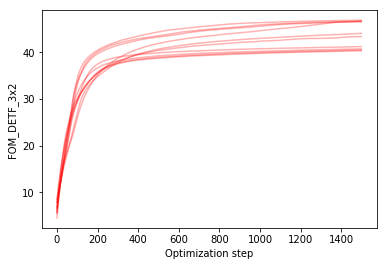

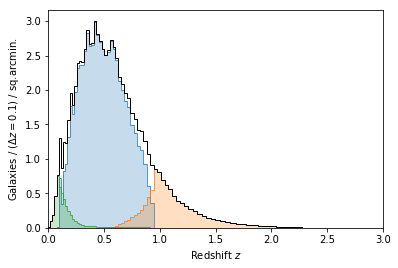

Skipping already completed job for nbin=4
Skipping already completed job for nbin=6
Skipping already completed job for nbin=8
Skipping already completed job for nbin=10


In [30]:
run_study('results/direct-detf', optimize_direct)

Skipping already completed job for nbin=2
Starting job at 2020-09-14 06:34:37.559687 with {'sample': 'buzzard', 'nbin': 3, 'ntrial': 10, 'nsteps': 2500, 'eta': 0.02, 'transform': 'extend', 'metric': 'SNR_3x2', 'method': 'jax', 'seed': 123}
  score=1168.258 (max=1168.258) after 625 steps.
  score=1170.668 (max=1170.668) after 1250 steps.
  score=1171.305 (max=1171.305) after 1875 steps.
  score=1171.568 (max=1171.568) after 2500 steps.
trial 1/10: score=1171.568 (max=1171.568) after 2500 steps.
  score=1164.609 (max=1171.568) after 625 steps.
  score=1168.866 (max=1171.568) after 1250 steps.
  score=1169.935 (max=1171.568) after 1875 steps.
  score=1170.366 (max=1171.568) after 2500 steps.
trial 2/10: score=1170.366 (max=1171.568) after 2500 steps.
  score=1164.163 (max=1171.568) after 625 steps.
  score=1168.142 (max=1171.568) after 1250 steps.
  score=1169.196 (max=1171.568) after 1875 steps.
  score=1169.638 (max=1171.568) after 2500 steps.
trial 3/10: score=1169.638 (max=1171.568) a

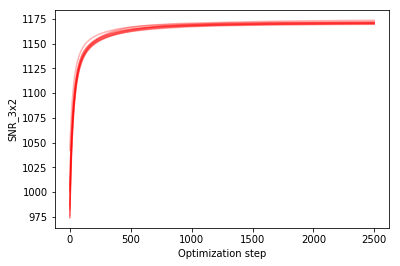

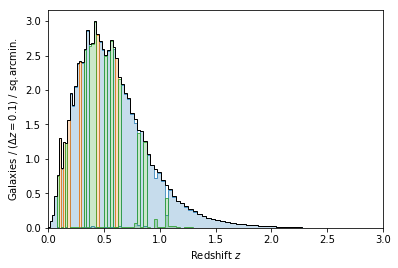

Skipping already completed job for nbin=4
Skipping already completed job for nbin=6
Skipping already completed job for nbin=8
Skipping already completed job for nbin=10


In [31]:
run_study('results/direct-snr', optimize_direct)

Skipping already completed job for nbin=2
Starting job at 2020-09-14 06:36:13.240459 with {'sample': 'buzzard', 'nbin': 3, 'ntrial': 30, 'nsteps': 2500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_3x2', 'method': 'jax', 'seed': 123}
  score=2863.296 (max=2863.296) after 625 steps.
  score=2928.915 (max=2928.915) after 1250 steps.
  score=3072.637 (max=3072.642) after 1875 steps.
  score=3076.405 (max=3076.547) after 2500 steps.
trial 1/30: score=3076.405 (max=3076.547) after 2500 steps.
  score=1971.288 (max=3076.547) after 625 steps.
  score=2062.808 (max=3076.547) after 1250 steps.
  score=2151.320 (max=3076.547) after 1875 steps.
  score=2199.416 (max=3076.547) after 2500 steps.
trial 2/30: score=2199.416 (max=3076.547) after 2500 steps.
  score=2080.892 (max=3076.547) after 625 steps.
  score=2146.790 (max=3076.547) after 1250 steps.
  score=2157.065 (max=3076.547) after 1875 steps.
  score=2162.777 (max=3076.547) after 2500 steps.
trial 3/30: score=2162.777 (max=3076.547) a

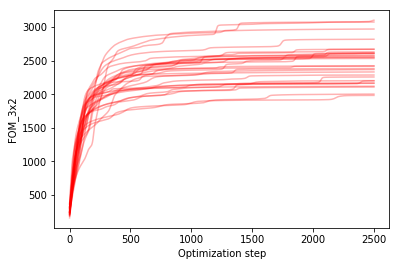

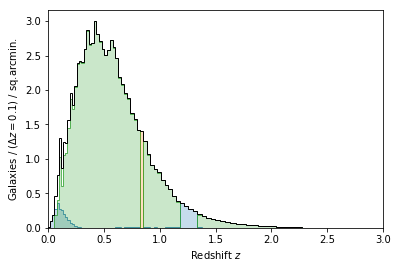

Skipping already completed job for nbin=4
Skipping already completed job for nbin=6
Skipping already completed job for nbin=8
Skipping already completed job for nbin=10


In [32]:
run_study('results/direct-fom', optimize_direct)

Skipping already completed job for nbin=2
Starting job at 2020-09-14 06:42:16.662028 with {'sample': 'dc2', 'nbin': 3, 'ntrial': 10, 'nsteps': 1500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=71.876 (max=71.876) after 375 steps.
  score=76.959 (max=76.959) after 750 steps.
  score=77.916 (max=77.918) after 1125 steps.
  score=78.320 (max=78.323) after 1500 steps.
trial 1/10: score=78.320 (max=78.323) after 1500 steps.
  score=75.393 (max=78.323) after 375 steps.
  score=77.912 (max=78.323) after 750 steps.
  score=78.983 (max=78.983) after 1125 steps.
  score=80.574 (max=80.574) after 1500 steps.
trial 2/10: score=80.574 (max=80.574) after 1500 steps.
  score=77.691 (max=80.574) after 375 steps.
  score=82.071 (max=82.071) after 750 steps.
  score=83.049 (max=83.051) after 1125 steps.
  score=83.386 (max=83.388) after 1500 steps.
trial 3/10: score=83.386 (max=83.388) after 1500 steps.
  score=74.505 (max=83.388) after 375 steps.


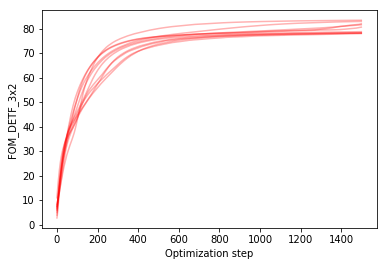

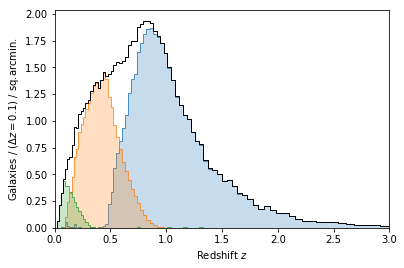

Skipping already completed job for nbin=4
Skipping already completed job for nbin=6
Skipping already completed job for nbin=8
Skipping already completed job for nbin=10


In [33]:
run_study('results/direct-detf-dc2', optimize_direct)

Skipping already completed job for nbin=2
Starting job at 2020-09-14 06:43:41.975513 with {'sample': 'dc2', 'nbin': 3, 'ntrial': 10, 'nsteps': 2500, 'eta': 0.02, 'transform': 'extend', 'metric': 'SNR_3x2', 'method': 'jax', 'seed': 123}
  score=1128.358 (max=1128.358) after 625 steps.
  score=1132.076 (max=1132.076) after 1250 steps.
  score=1133.064 (max=1133.064) after 1875 steps.
  score=1133.487 (max=1133.487) after 2500 steps.
trial 1/10: score=1133.487 (max=1133.487) after 2500 steps.
  score=1125.098 (max=1133.487) after 625 steps.
  score=1130.633 (max=1133.487) after 1250 steps.
  score=1132.084 (max=1133.487) after 1875 steps.
  score=1132.681 (max=1133.487) after 2500 steps.
trial 2/10: score=1132.681 (max=1133.487) after 2500 steps.
  score=1126.211 (max=1133.487) after 625 steps.
  score=1130.618 (max=1133.487) after 1250 steps.
  score=1131.851 (max=1133.487) after 1875 steps.
  score=1132.384 (max=1133.487) after 2500 steps.
trial 3/10: score=1132.384 (max=1133.487) after

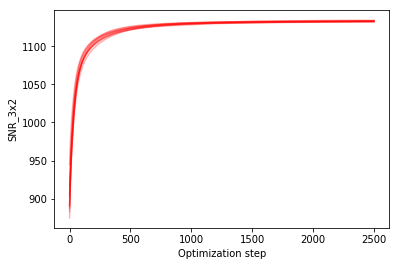

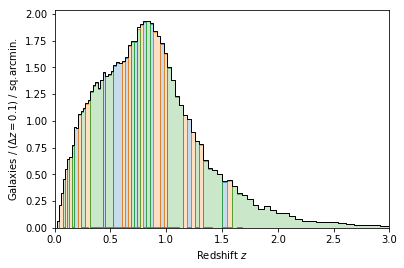

Skipping already completed job for nbin=4
Skipping already completed job for nbin=6
Skipping already completed job for nbin=8
Skipping already completed job for nbin=10


In [34]:
run_study('results/direct-snr-dc2', optimize_direct)

Skipping already completed job for nbin=2
Starting job at 2020-09-14 06:45:16.659731 with {'sample': 'dc2', 'nbin': 3, 'ntrial': 30, 'nsteps': 2500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_3x2', 'method': 'jax', 'seed': 123}
  score=3332.676 (max=3332.676) after 625 steps.
  score=3765.358 (max=3765.358) after 1250 steps.
  score=3786.314 (max=3786.314) after 1875 steps.
  score=3791.823 (max=3791.921) after 2500 steps.
trial 1/30: score=3791.823 (max=3791.921) after 2500 steps.
  score=2792.511 (max=3791.921) after 625 steps.
  score=2813.011 (max=3791.921) after 1250 steps.
  score=2818.617 (max=3791.921) after 1875 steps.
  score=2821.453 (max=3791.921) after 2500 steps.
trial 2/30: score=2821.453 (max=3791.921) after 2500 steps.
  score=2746.221 (max=3791.921) after 625 steps.
  score=2885.398 (max=3791.921) after 1250 steps.
  score=2895.880 (max=3791.921) after 1875 steps.
  score=2899.389 (max=3791.921) after 2500 steps.
trial 3/30: score=2899.389 (max=3791.921) after

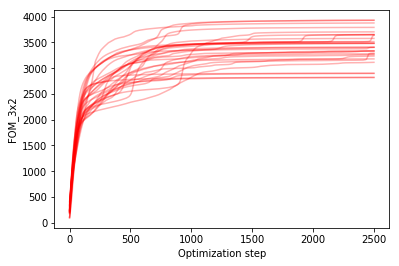

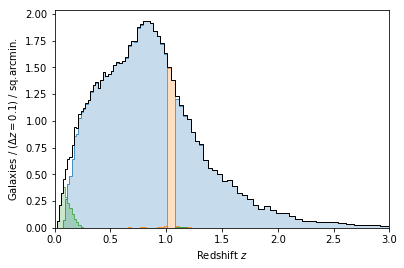

Skipping already completed job for nbin=4
Skipping already completed job for nbin=6
Skipping already completed job for nbin=8
Skipping already completed job for nbin=10


In [35]:
run_study('results/direct-fom-dc2', optimize_direct)

Starting job at 2020-09-14 07:32:03.345191 with {'sample': 'dc2', 'nbin': 2, 'ntrial': 30, 'nsteps': 1500, 'eta': 0.02, 'transform': 'softmax', 'metric': 'FOM_3x2', 'method': 'jax', 'seed': 123}
  score=1512.031 (max=1512.031) after 375 steps.
  score=1598.457 (max=1598.486) after 750 steps.
  score=1603.336 (max=1603.336) after 1125 steps.
  score=1604.385 (max=1604.515) after 1500 steps.
trial 1/30: score=1604.385 (max=1604.515) after 1500 steps.
  score=1512.014 (max=1604.515) after 375 steps.
  score=1598.639 (max=1604.515) after 750 steps.
  score=1603.116 (max=1604.515) after 1125 steps.
  score=1604.301 (max=1604.515) after 1500 steps.
trial 2/30: score=1604.301 (max=1604.515) after 1500 steps.
  score=1321.006 (max=1604.515) after 375 steps.
  score=1385.094 (max=1604.515) after 750 steps.
  score=1386.609 (max=1604.515) after 1125 steps.
  score=1451.314 (max=1604.515) after 1500 steps.
trial 3/30: score=1451.314 (max=1604.515) after 1500 steps.
  score=1256.408 (max=1604.515)

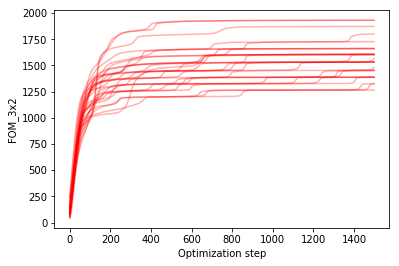

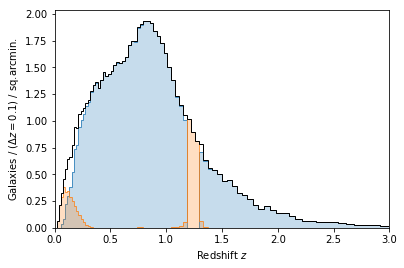

Starting job at 2020-09-14 07:35:39.597508 with {'sample': 'dc2', 'nbin': 3, 'ntrial': 30, 'nsteps': 2500, 'eta': 0.02, 'transform': 'softmax', 'metric': 'FOM_3x2', 'method': 'jax', 'seed': 123}
  score=3024.165 (max=3024.165) after 625 steps.
  score=3503.657 (max=3503.657) after 1250 steps.
  score=3601.394 (max=3601.394) after 1875 steps.
  score=3788.572 (max=3788.669) after 2500 steps.
trial 1/30: score=3788.572 (max=3788.669) after 2500 steps.
  score=3500.097 (max=3788.669) after 625 steps.
  score=3609.980 (max=3788.669) after 1250 steps.
  score=3654.692 (max=3788.669) after 1875 steps.
  score=3656.049 (max=3788.669) after 2500 steps.
trial 2/30: score=3656.049 (max=3788.669) after 2500 steps.
  score=3394.965 (max=3788.669) after 625 steps.
  score=3485.803 (max=3788.669) after 1250 steps.
  score=3517.873 (max=3788.669) after 1875 steps.
  score=3518.821 (max=3788.669) after 2500 steps.
trial 3/30: score=3518.821 (max=3788.669) after 2500 steps.
  score=3382.233 (max=3788.6

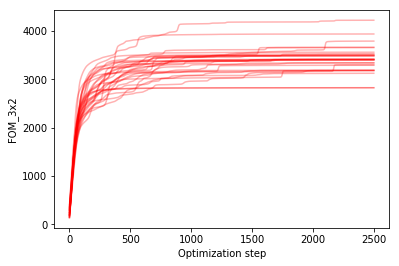

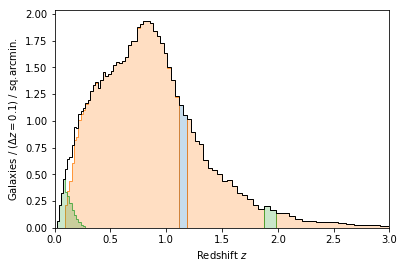

Starting job at 2020-09-14 07:41:35.832476 with {'sample': 'dc2', 'nbin': 4, 'ntrial': 30, 'nsteps': 3000, 'eta': 0.02, 'transform': 'softmax', 'metric': 'FOM_3x2', 'method': 'jax', 'seed': 123}
  score=6003.564 (max=6003.682) after 750 steps.
  score=6072.591 (max=6072.725) after 1500 steps.
  score=6092.001 (max=6092.144) after 2250 steps.
  score=6098.701 (max=6098.953) after 3000 steps.
trial 1/30: score=6098.701 (max=6098.953) after 3000 steps.
  score=4811.320 (max=6098.953) after 750 steps.
  score=4876.502 (max=6098.953) after 1500 steps.
  score=4963.255 (max=6098.953) after 2250 steps.
  score=5267.784 (max=6098.953) after 3000 steps.
trial 2/30: score=5267.784 (max=6098.953) after 3000 steps.
  score=5590.257 (max=6098.953) after 750 steps.
  score=5821.948 (max=6098.953) after 1500 steps.
  score=5833.559 (max=6098.953) after 2250 steps.
  score=5841.249 (max=6098.953) after 3000 steps.
trial 3/30: score=5841.249 (max=6098.953) after 3000 steps.
  score=4625.972 (max=6098.9

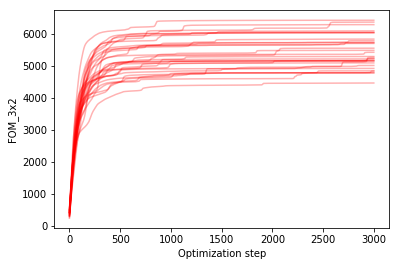

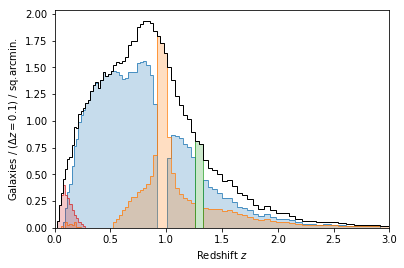

Starting job at 2020-09-14 07:53:51.964354 with {'sample': 'dc2', 'nbin': 6, 'ntrial': 30, 'nsteps': 4500, 'eta': 0.02, 'transform': 'softmax', 'metric': 'FOM_3x2', 'method': 'jax', 'seed': 123}
  score=8972.377 (max=8972.880) after 1125 steps.
  score=9178.231 (max=9178.329) after 2250 steps.
  score=9189.584 (max=9190.341) after 3375 steps.
  score=9297.475 (max=9297.933) after 4500 steps.
trial 1/30: score=9297.475 (max=9297.933) after 4500 steps.
  score=8991.995 (max=9297.933) after 1125 steps.
  score=9115.887 (max=9297.933) after 2250 steps.
  score=9126.111 (max=9297.933) after 3375 steps.
  score=9237.101 (max=9297.933) after 4500 steps.
trial 2/30: score=9237.101 (max=9297.933) after 4500 steps.
  score=7290.588 (max=9297.933) after 1125 steps.
  score=7299.319 (max=9297.933) after 2250 steps.
  score=7301.704 (max=9297.933) after 3375 steps.
  score=7302.038 (max=9297.933) after 4500 steps.
trial 3/30: score=7302.038 (max=9297.933) after 4500 steps.
  score=8710.523 (max=929

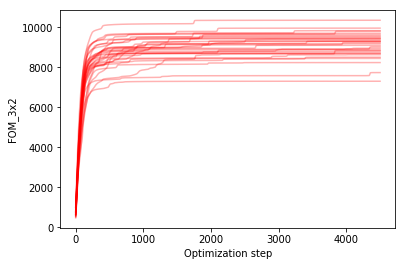

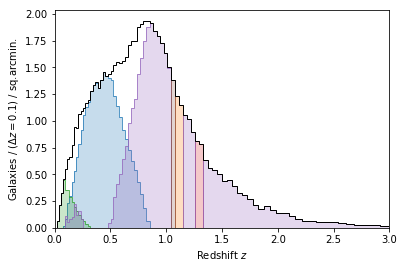

Starting job at 2020-09-14 08:33:38.629814 with {'sample': 'dc2', 'nbin': 8, 'ntrial': 30, 'nsteps': 6000, 'eta': 0.02, 'transform': 'softmax', 'metric': 'FOM_3x2', 'method': 'jax', 'seed': 123}
  score=11484.372 (max=11485.893) after 1500 steps.
  score=11700.233 (max=11700.749) after 3000 steps.
  score=11830.714 (max=11831.678) after 4500 steps.
  score=11832.071 (max=11833.048) after 6000 steps.
trial 1/30: score=11832.071 (max=11833.048) after 6000 steps.
  score=11863.627 (max=11863.627) after 1500 steps.
  score=12184.969 (max=12185.399) after 3000 steps.
  score=12357.979 (max=12357.979) after 4500 steps.
  score=12424.351 (max=12424.954) after 6000 steps.
trial 2/30: score=12424.351 (max=12424.954) after 6000 steps.
  score=11084.830 (max=12424.954) after 1500 steps.
  score=11248.230 (max=12424.954) after 3000 steps.
  score=11366.940 (max=12424.954) after 4500 steps.
  score=11367.454 (max=12424.954) after 6000 steps.
trial 3/30: score=11367.454 (max=12424.954) after 6000 st

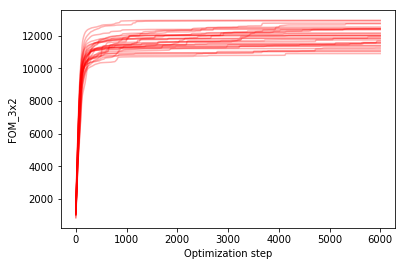

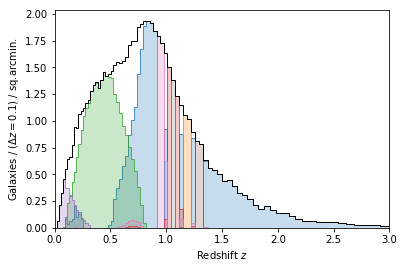

Starting job at 2020-09-14 09:43:36.036139 with {'sample': 'dc2', 'nbin': 10, 'ntrial': 30, 'nsteps': 7500, 'eta': 0.02, 'transform': 'softmax', 'metric': 'FOM_3x2', 'method': 'jax', 'seed': 123}
  score=13888.020 (max=13888.580) after 1875 steps.
  score=13986.544 (max=13987.313) after 3750 steps.
  score=14046.956 (max=14047.592) after 5625 steps.
  score=14115.290 (max=14115.826) after 7500 steps.
trial 1/30: score=14115.290 (max=14115.826) after 7500 steps.
  score=12816.181 (max=14115.826) after 1875 steps.
  score=12822.084 (max=14115.826) after 3750 steps.
  score=12925.450 (max=14115.826) after 5625 steps.
  score=12930.507 (max=14115.826) after 7500 steps.
trial 2/30: score=12930.507 (max=14115.826) after 7500 steps.
  score=15526.829 (max=15526.829) after 1875 steps.
  score=15675.185 (max=15676.542) after 3750 steps.
  score=15678.634 (max=15679.264) after 5625 steps.
  score=15678.010 (max=15679.666) after 7500 steps.
trial 3/30: score=15678.010 (max=15679.666) after 7500 s

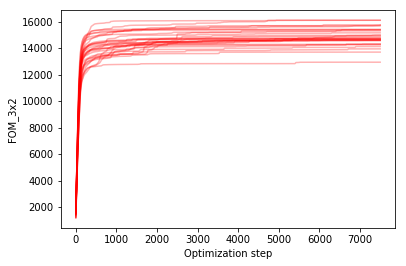

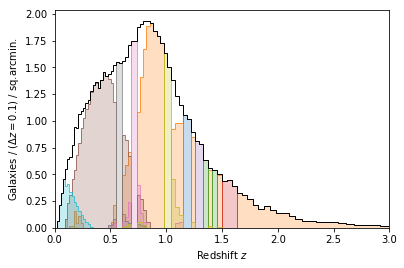

In [47]:
run_study('results/direct-fom-dc2-softmax', optimize_direct)

## Optimize redshift bins using features

In [11]:
def optimize_bins(nbin, groups, ntrial, nsteps, eta, transform, metric, method, seed, independent=False, init_data=init_data):
    _, _, _, zhist, _ = load_groups(groups + '.npz')
    ngrp, nzin = zhist.shape
    nzout = len(init_data[0]) - 1
    assert nzin % nzout == 0
    downsampling = nzin // nzout
    if downsampling > 1:
        print(f'Downsampling by {downsampling}.')
        zhist = zhist.reshape(ngrp, nzout, downsampling).sum(axis=-1)
    return optimize(
        nbin, zhist, init_data, ntrial=ntrial, interval=nsteps // 4,
        transform=transform, method=method, metric=metric, independent=independent, seed=seed,
        opt_args=dict(optimizer=optimizers.adam(eta), nsteps=nsteps))

Starting job at 2020-09-14 15:50:03.372681 with {'groups': 'group_cos_80_150', 'nbin': 2, 'independent': True, 'ntrial': 10, 'nsteps': 3000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=21.028 (max=21.028) after 750 steps.
  score=21.274 (max=21.275) after 1500 steps.
  score=21.343 (max=21.344) after 2250 steps.
  score=21.370 (max=21.373) after 3000 steps.
trial 1/10: score=21.370 (max=21.373) after 3000 steps.
  score=21.119 (max=21.373) after 750 steps.
  score=21.306 (max=21.373) after 1500 steps.
  score=21.357 (max=21.373) after 2250 steps.
  score=21.377 (max=21.379) after 3000 steps.
trial 2/10: score=21.377 (max=21.379) after 3000 steps.
  score=21.060 (max=21.379) after 750 steps.
  score=21.285 (max=21.379) after 1500 steps.
  score=21.347 (max=21.379) after 2250 steps.
  score=21.371 (max=21.379) after 3000 steps.
trial 3/10: score=21.371 (max=21.379) after 3000 steps.
  score=21.098 (max=21.379) after 750 steps.
  sco

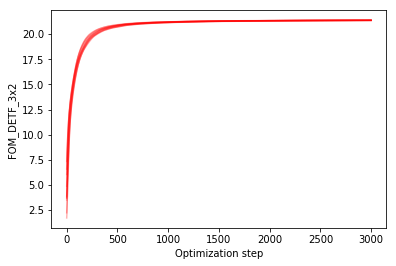

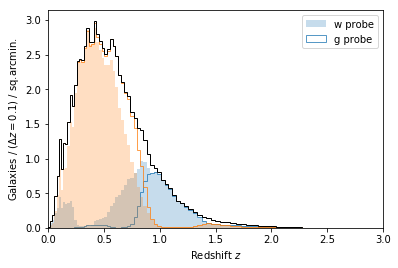

Starting job at 2020-09-14 15:52:01.203950 with {'groups': 'group_cos_80_150', 'nbin': 3, 'independent': True, 'ntrial': 10, 'nsteps': 5000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=39.563 (max=39.563) after 1250 steps.
  score=42.646 (max=42.648) after 2500 steps.
  score=42.717 (max=42.718) after 3750 steps.
  score=42.738 (max=42.741) after 5000 steps.
trial 1/10: score=42.738 (max=42.741) after 5000 steps.
  score=42.179 (max=42.741) after 1250 steps.
  score=42.640 (max=42.741) after 2500 steps.
  score=42.706 (max=42.741) after 3750 steps.
  score=42.734 (max=42.741) after 5000 steps.
trial 2/10: score=42.734 (max=42.741) after 5000 steps.
  score=40.621 (max=42.741) after 1250 steps.
  score=41.361 (max=42.741) after 2500 steps.
  score=41.884 (max=42.741) after 3750 steps.
  score=42.187 (max=42.741) after 5000 steps.
trial 3/10: score=42.187 (max=42.741) after 5000 steps.
  score=40.485 (max=42.741) after 1250 steps.
 

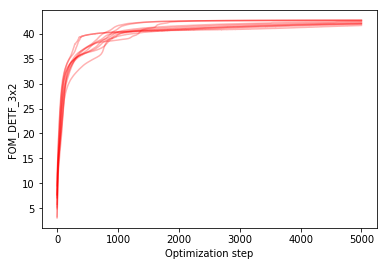

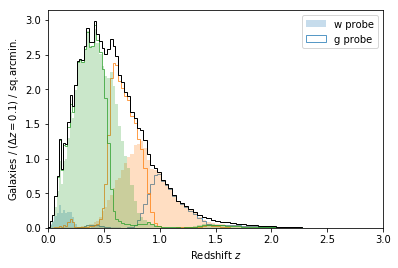

Starting job at 2020-09-14 15:55:24.035432 with {'groups': 'group_cos_80_150', 'nbin': 4, 'independent': True, 'ntrial': 10, 'nsteps': 6000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=55.577 (max=55.579) after 1500 steps.
  score=56.503 (max=56.509) after 3000 steps.
  score=56.733 (max=56.753) after 4500 steps.
  score=56.869 (max=56.888) after 6000 steps.
trial 1/10: score=56.869 (max=56.888) after 6000 steps.
  score=56.409 (max=56.888) after 1500 steps.
  score=56.888 (max=56.894) after 3000 steps.
  score=56.983 (max=57.000) after 4500 steps.
  score=57.038 (max=57.047) after 6000 steps.
trial 2/10: score=57.038 (max=57.047) after 6000 steps.
  score=55.862 (max=57.047) after 1500 steps.
  score=56.720 (max=57.047) after 3000 steps.
  score=56.924 (max=57.047) after 4500 steps.
  score=57.026 (max=57.047) after 6000 steps.
trial 3/10: score=57.026 (max=57.047) after 6000 steps.
  score=56.041 (max=57.047) after 1500 steps.
 

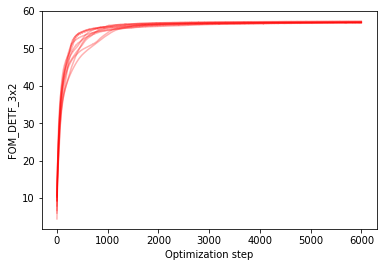

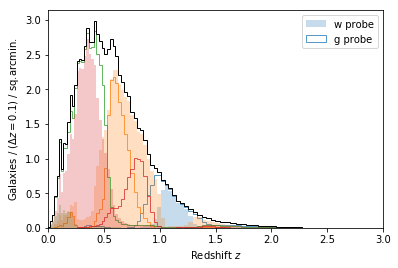

Starting job at 2020-09-14 16:03:17.649825 with {'groups': 'group_cos_80_150', 'nbin': 6, 'independent': True, 'ntrial': 10, 'nsteps': 9000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=68.738 (max=68.744) after 2250 steps.
  score=69.712 (max=69.742) after 4500 steps.
  score=70.126 (max=70.139) after 6750 steps.
  score=70.324 (max=70.351) after 9000 steps.
trial 1/10: score=70.324 (max=70.351) after 9000 steps.
  score=69.601 (max=70.351) after 2250 steps.
  score=70.382 (max=70.407) after 4500 steps.
  score=70.611 (max=70.629) after 6750 steps.
  score=70.723 (max=70.724) after 9000 steps.
trial 2/10: score=70.723 (max=70.724) after 9000 steps.
  score=69.055 (max=70.724) after 2250 steps.
  score=70.016 (max=70.724) after 4500 steps.
  score=70.383 (max=70.724) after 6750 steps.
  score=70.581 (max=70.724) after 9000 steps.
trial 3/10: score=70.581 (max=70.724) after 9000 steps.
  score=68.256 (max=70.724) after 2250 steps.
 

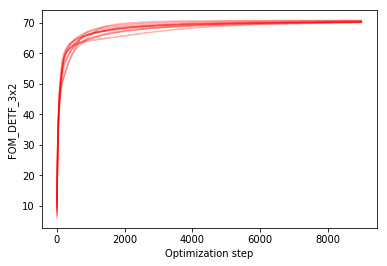

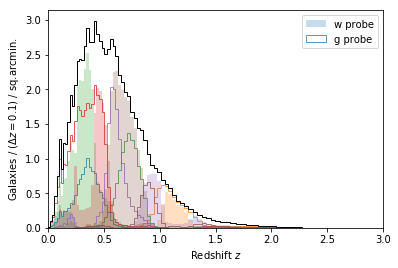

Starting job at 2020-09-14 16:29:34.715948 with {'groups': 'group_cos_80_150', 'nbin': 8, 'independent': True, 'ntrial': 10, 'nsteps': 12000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=78.021 (max=78.079) after 3000 steps.
  score=79.194 (max=79.228) after 6000 steps.
  score=79.641 (max=79.692) after 9000 steps.
  score=79.872 (max=79.928) after 12000 steps.
trial 1/10: score=79.872 (max=79.928) after 12000 steps.
  score=79.242 (max=79.928) after 3000 steps.
  score=80.204 (max=80.263) after 6000 steps.
  score=80.864 (max=80.875) after 9000 steps.
  score=81.081 (max=81.103) after 12000 steps.
trial 2/10: score=81.081 (max=81.103) after 12000 steps.
  score=78.694 (max=81.103) after 3000 steps.
  score=80.091 (max=81.103) after 6000 steps.
  score=80.589 (max=81.103) after 9000 steps.
  score=81.049 (max=81.103) after 12000 steps.
trial 3/10: score=81.049 (max=81.103) after 12000 steps.
  score=78.545 (max=81.103) after 3000 s

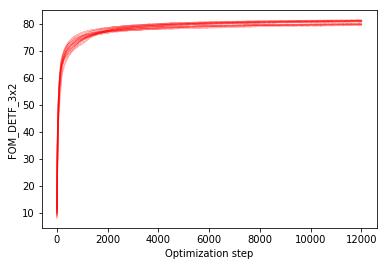

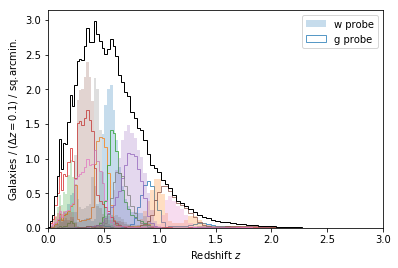

Starting job at 2020-09-14 17:15:10.536701 with {'groups': 'group_cos_80_150', 'nbin': 10, 'independent': True, 'ntrial': 10, 'nsteps': 15000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=87.644 (max=87.718) after 3750 steps.
  score=88.819 (max=88.860) after 7500 steps.
  score=89.261 (max=89.302) after 11250 steps.
  score=89.515 (max=89.565) after 15000 steps.
trial 1/10: score=89.515 (max=89.565) after 15000 steps.
  score=87.453 (max=89.565) after 3750 steps.
  score=89.050 (max=89.565) after 7500 steps.
  score=89.603 (max=89.629) after 11250 steps.
  score=89.844 (max=89.858) after 15000 steps.
trial 2/10: score=89.844 (max=89.858) after 15000 steps.
  score=88.201 (max=89.858) after 3750 steps.
  score=89.410 (max=89.858) after 7500 steps.
  score=89.792 (max=89.858) after 11250 steps.
  score=89.894 (max=89.948) after 15000 steps.
trial 3/10: score=89.894 (max=89.948) after 15000 steps.
  score=88.012 (max=89.948) after 37

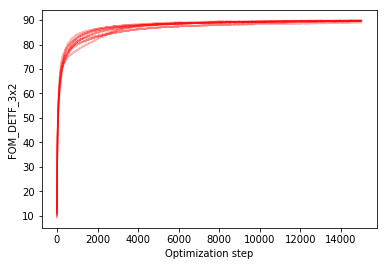

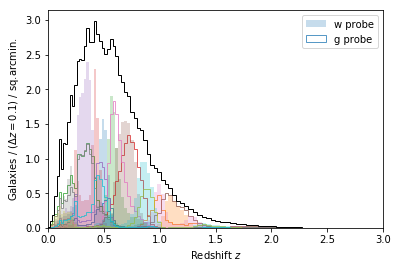

In [12]:
run_study('results/cos-150-detf-gw', optimize_bins)

In [13]:
run_study('results/cos-150-detf-dc2-gw', optimize_bins)

Starting job at 2020-09-14 18:54:51.632713 with {'groups': 'group_cos_150_dc2', 'nbin': 2, 'independent': True, 'ntrial': 10, 'nsteps': 3000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=40.651 (max=40.651) after 750 steps.
  score=40.976 (max=40.976) after 1500 steps.
  score=41.057 (max=41.059) after 2250 steps.


KeyboardInterrupt: 

Starting job at 2020-09-14 18:55:35.567057 with {'groups': 'group_cos_80_150', 'nbin': 2, 'ntrial': 10, 'independent': True, 'nsteps': 3000, 'eta': 0.02, 'transform': 'extend', 'metric': 'SNR_3x2', 'method': 'jax', 'seed': 123}
  score=952.348 (max=952.348) after 750 steps.
  score=954.422 (max=954.422) after 1500 steps.
  score=955.021 (max=955.021) after 2250 steps.
  score=955.279 (max=955.279) after 3000 steps.
trial 1/10: score=955.279 (max=955.279) after 3000 steps.
  score=941.030 (max=955.279) after 750 steps.
  score=944.717 (max=955.279) after 1500 steps.
  score=945.408 (max=955.279) after 2250 steps.
  score=945.677 (max=955.279) after 3000 steps.
trial 2/10: score=945.677 (max=955.279) after 3000 steps.
  score=948.094 (max=955.279) after 750 steps.
  score=950.540 (max=955.279) after 1500 steps.
  score=951.063 (max=955.279) after 2250 steps.
  score=951.300 (max=955.279) after 3000 steps.
trial 3/10: score=951.300 (max=955.279) after 3000 steps.
  score=949.945 (max=955.

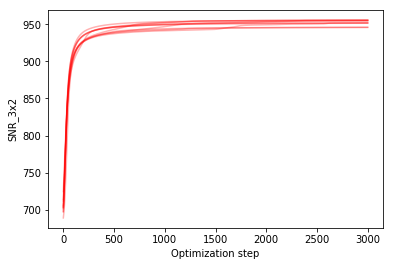

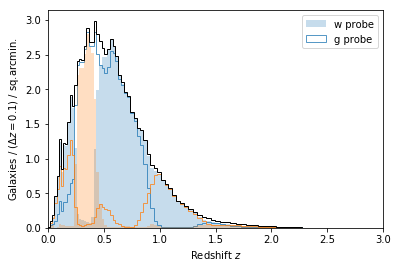

Starting job at 2020-09-14 18:57:06.656756 with {'groups': 'group_cos_80_150', 'nbin': 3, 'ntrial': 10, 'independent': True, 'nsteps': 5000, 'eta': 0.02, 'transform': 'extend', 'metric': 'SNR_3x2', 'method': 'jax', 'seed': 123}
  score=1147.165 (max=1147.165) after 1250 steps.
  score=1151.346 (max=1151.346) after 2500 steps.
  score=1152.994 (max=1152.994) after 3750 steps.
  score=1153.236 (max=1153.236) after 5000 steps.
trial 1/10: score=1153.236 (max=1153.236) after 5000 steps.
  score=1145.130 (max=1153.236) after 1250 steps.
  score=1147.964 (max=1153.236) after 2500 steps.
  score=1149.571 (max=1153.236) after 3750 steps.
  score=1152.216 (max=1153.236) after 5000 steps.
trial 2/10: score=1152.216 (max=1153.236) after 5000 steps.
  score=1150.516 (max=1153.236) after 1250 steps.
  score=1153.556 (max=1153.556) after 2500 steps.
  score=1154.370 (max=1154.370) after 3750 steps.
  score=1154.656 (max=1154.656) after 5000 steps.
trial 3/10: score=1154.656 (max=1154.656) after 5000

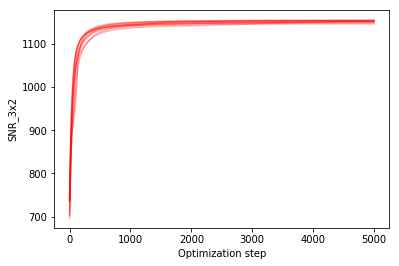

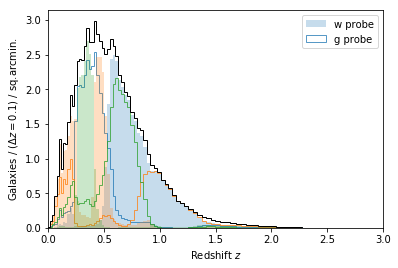

Starting job at 2020-09-14 18:59:49.155518 with {'groups': 'group_cos_80_150', 'nbin': 4, 'ntrial': 10, 'independent': True, 'nsteps': 6000, 'eta': 0.02, 'transform': 'extend', 'metric': 'SNR_3x2', 'method': 'jax', 'seed': 123}
  score=1311.863 (max=1311.863) after 1500 steps.
  score=1315.190 (max=1315.190) after 3000 steps.
  score=1316.051 (max=1316.051) after 4500 steps.
  score=1316.373 (max=1316.374) after 6000 steps.
trial 1/10: score=1316.373 (max=1316.374) after 6000 steps.
  score=1297.751 (max=1316.374) after 1500 steps.
  score=1305.716 (max=1316.374) after 3000 steps.
  score=1308.593 (max=1316.374) after 4500 steps.
  score=1309.124 (max=1316.374) after 6000 steps.
trial 2/10: score=1309.124 (max=1316.374) after 6000 steps.
  score=1307.585 (max=1316.374) after 1500 steps.
  score=1311.437 (max=1316.374) after 3000 steps.
  score=1312.355 (max=1316.374) after 4500 steps.
  score=1312.718 (max=1316.374) after 6000 steps.
trial 3/10: score=1312.718 (max=1316.374) after 6000

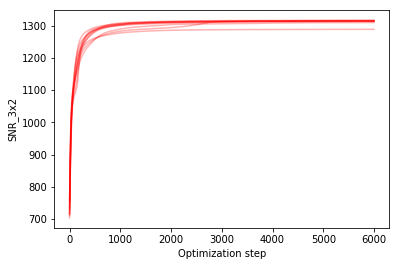

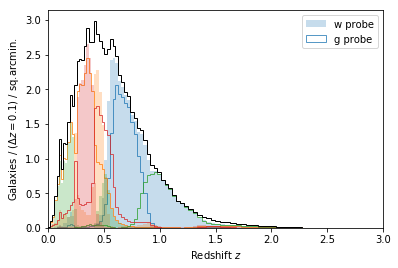

Starting job at 2020-09-14 19:07:23.349228 with {'groups': 'group_cos_80_150', 'nbin': 6, 'ntrial': 10, 'independent': True, 'nsteps': 8000, 'eta': 0.02, 'transform': 'extend', 'metric': 'SNR_3x2', 'method': 'jax', 'seed': 123}
  score=1545.192 (max=1545.192) after 2000 steps.
  score=1550.727 (max=1550.727) after 4000 steps.
  score=1551.835 (max=1551.835) after 6000 steps.
  score=1552.177 (max=1552.178) after 8000 steps.
trial 1/10: score=1552.177 (max=1552.178) after 8000 steps.
  score=1536.113 (max=1552.178) after 2000 steps.
  score=1553.114 (max=1553.114) after 4000 steps.
  score=1556.167 (max=1556.167) after 6000 steps.
  score=1556.554 (max=1556.554) after 8000 steps.
trial 2/10: score=1556.554 (max=1556.554) after 8000 steps.
  score=1549.877 (max=1556.554) after 2000 steps.
  score=1556.008 (max=1556.554) after 4000 steps.
  score=1557.238 (max=1557.238) after 6000 steps.
  score=1557.615 (max=1557.615) after 8000 steps.
trial 3/10: score=1557.615 (max=1557.615) after 8000

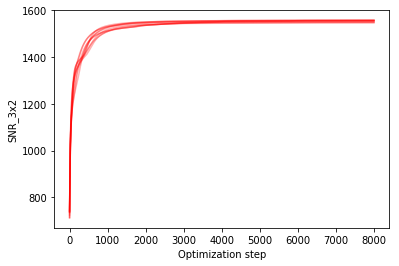

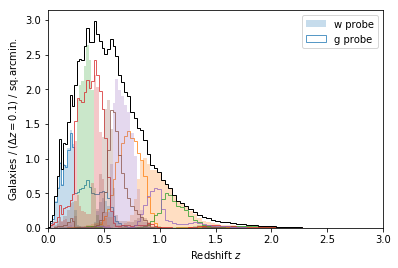

Starting job at 2020-09-14 19:30:28.756047 with {'groups': 'group_cos_80_150', 'nbin': 8, 'ntrial': 10, 'independent': True, 'nsteps': 9000, 'eta': 0.02, 'transform': 'extend', 'metric': 'SNR_3x2', 'method': 'jax', 'seed': 123}
  score=1688.153 (max=1688.153) after 2250 steps.
  score=1698.704 (max=1698.711) after 4500 steps.
  score=1700.742 (max=1700.745) after 6750 steps.
  score=1701.476 (max=1701.476) after 9000 steps.
trial 1/10: score=1701.476 (max=1701.476) after 9000 steps.
  score=1712.291 (max=1712.291) after 2250 steps.
  score=1720.311 (max=1720.311) after 4500 steps.
  score=1721.845 (max=1721.845) after 6750 steps.
  score=1722.292 (max=1722.292) after 9000 steps.
trial 2/10: score=1722.292 (max=1722.292) after 9000 steps.
  score=1705.818 (max=1722.292) after 2250 steps.
  score=1715.211 (max=1722.292) after 4500 steps.
  score=1716.866 (max=1722.292) after 6750 steps.
  score=1717.337 (max=1722.292) after 9000 steps.
trial 3/10: score=1717.337 (max=1722.292) after 9000

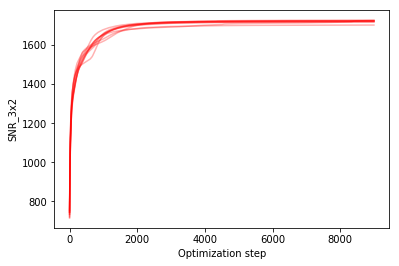

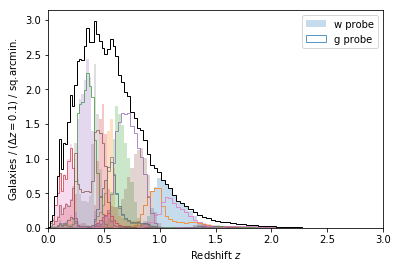

Starting job at 2020-09-14 20:04:11.625667 with {'groups': 'group_cos_80_150', 'nbin': 10, 'ntrial': 10, 'independent': True, 'nsteps': 10000, 'eta': 0.02, 'transform': 'extend', 'metric': 'SNR_3x2', 'method': 'jax', 'seed': 123}
  score=1825.876 (max=1825.876) after 2500 steps.
  score=1843.938 (max=1843.938) after 5000 steps.
  score=1846.409 (max=1846.409) after 7500 steps.
  score=1847.026 (max=1847.027) after 10000 steps.
trial 1/10: score=1847.026 (max=1847.027) after 10000 steps.
  score=1812.459 (max=1847.027) after 2500 steps.
  score=1834.476 (max=1847.027) after 5000 steps.
  score=1841.733 (max=1847.027) after 7500 steps.
  score=1842.394 (max=1847.027) after 10000 steps.
trial 2/10: score=1842.394 (max=1847.027) after 10000 steps.
  score=1813.614 (max=1847.027) after 2500 steps.
  score=1828.739 (max=1847.027) after 5000 steps.
  score=1834.836 (max=1847.027) after 7500 steps.
  score=1835.607 (max=1847.027) after 10000 steps.
trial 3/10: score=1835.607 (max=1847.027) aft

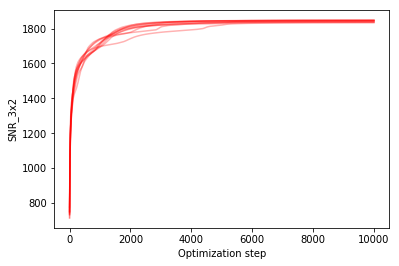

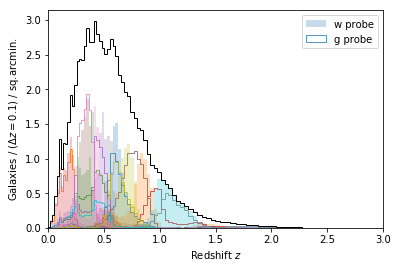

In [14]:
run_study('results/cos-150-snr-gw', optimize_bins)

Running job with {'groups': 'group_emd_80_300', 'nbin': 2, 'ntrial': 10, 'nsteps': 1500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=18.752 (max=18.752) after 375 steps.
  score=19.682 (max=19.682) after 750 steps.
  score=20.034 (max=20.035) after 1125 steps.
  score=20.168 (max=20.169) after 1500 steps.
trial 1/10: score=20.168 (max=20.169) after 1500 steps.
  score=18.649 (max=20.169) after 375 steps.
  score=19.624 (max=20.169) after 750 steps.
  score=20.020 (max=20.169) after 1125 steps.
  score=20.167 (max=20.169) after 1500 steps.
trial 2/10: score=20.167 (max=20.169) after 1500 steps.
  score=18.570 (max=20.169) after 375 steps.
  score=19.670 (max=20.169) after 750 steps.
  score=20.039 (max=20.169) after 1125 steps.
  score=20.166 (max=20.169) after 1500 steps.
trial 3/10: score=20.166 (max=20.169) after 1500 steps.
  score=18.571 (max=20.169) after 375 steps.
  score=19.585 (max=20.169) after 750 steps.
  score=19.943 

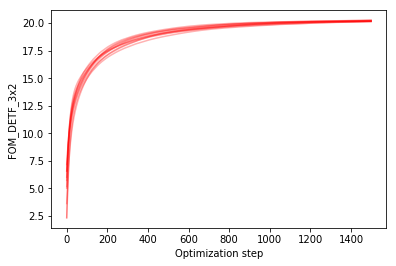

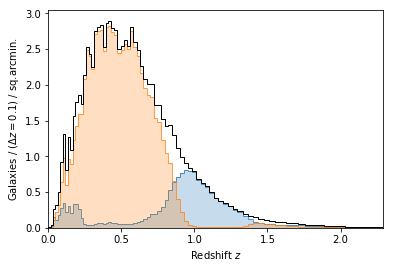

Running job with {'groups': 'group_emd_80_300', 'nbin': 4, 'ntrial': 10, 'nsteps': 3000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=52.925 (max=52.925) after 750 steps.
  score=54.055 (max=54.057) after 1500 steps.
  score=54.387 (max=54.392) after 2250 steps.
  score=54.553 (max=54.554) after 3000 steps.
trial 1/10: score=54.553 (max=54.554) after 3000 steps.
  score=52.212 (max=54.554) after 750 steps.
  score=54.348 (max=54.554) after 1500 steps.
  score=54.758 (max=54.759) after 2250 steps.
  score=54.866 (max=54.866) after 3000 steps.
trial 2/10: score=54.866 (max=54.866) after 3000 steps.
  score=50.931 (max=54.866) after 750 steps.
  score=53.400 (max=54.866) after 1500 steps.
  score=54.073 (max=54.866) after 2250 steps.
  score=54.403 (max=54.866) after 3000 steps.
trial 3/10: score=54.403 (max=54.866) after 3000 steps.
  score=50.820 (max=54.866) after 750 steps.
  score=53.177 (max=54.866) after 1500 steps.
  score=54.

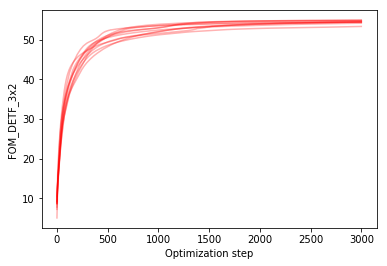

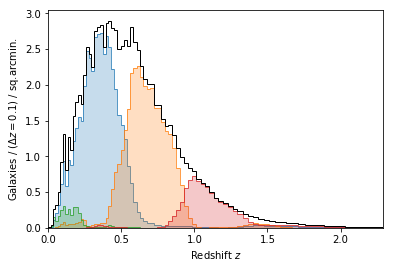

Running job with {'groups': 'group_emd_80_300', 'nbin': 6, 'ntrial': 10, 'nsteps': 4500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=63.730 (max=63.750) after 1125 steps.
  score=66.081 (max=66.102) after 2250 steps.
  score=67.348 (max=67.348) after 3375 steps.
  score=68.057 (max=68.063) after 4500 steps.
trial 1/10: score=68.057 (max=68.063) after 4500 steps.
  score=64.464 (max=68.063) after 1125 steps.
  score=65.891 (max=68.063) after 2250 steps.
  score=66.519 (max=68.063) after 3375 steps.
  score=66.958 (max=68.063) after 4500 steps.
trial 2/10: score=66.958 (max=68.063) after 4500 steps.
  score=64.454 (max=68.063) after 1125 steps.
  score=66.114 (max=68.063) after 2250 steps.
  score=66.896 (max=68.063) after 3375 steps.
  score=67.387 (max=68.063) after 4500 steps.
trial 3/10: score=67.387 (max=68.063) after 4500 steps.
  score=64.627 (max=68.063) after 1125 steps.
  score=66.486 (max=68.063) after 2250 steps.
  score

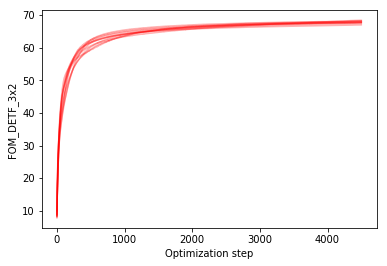

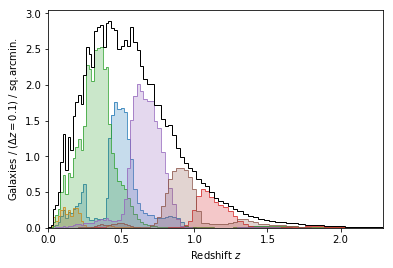

Running job with {'groups': 'group_emd_80_300', 'nbin': 8, 'ntrial': 10, 'nsteps': 6000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=71.710 (max=71.710) after 1500 steps.
  score=74.673 (max=74.677) after 3000 steps.
  score=76.120 (max=76.138) after 4500 steps.
  score=76.729 (max=76.729) after 6000 steps.
trial 1/10: score=76.729 (max=76.729) after 6000 steps.
  score=74.573 (max=76.729) after 1500 steps.
  score=77.402 (max=77.409) after 3000 steps.
  score=78.391 (max=78.394) after 4500 steps.
  score=78.841 (max=78.843) after 6000 steps.
trial 2/10: score=78.841 (max=78.843) after 6000 steps.
  score=75.480 (max=78.843) after 1500 steps.
  score=77.484 (max=78.843) after 3000 steps.
  score=78.221 (max=78.843) after 4500 steps.
  score=78.680 (max=78.843) after 6000 steps.
trial 3/10: score=78.680 (max=78.843) after 6000 steps.
  score=73.366 (max=78.843) after 1500 steps.
  score=75.275 (max=78.843) after 3000 steps.
  score

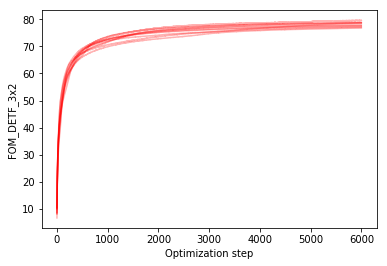

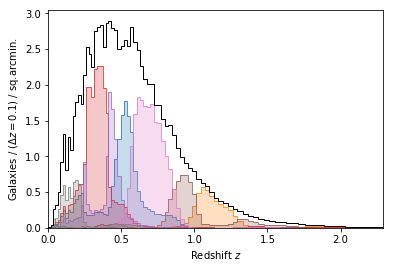

Running job with {'groups': 'group_emd_80_300', 'nbin': 10, 'ntrial': 10, 'nsteps': 7500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=81.101 (max=81.120) after 1875 steps.
  score=85.266 (max=85.266) after 3750 steps.
  score=86.467 (max=86.471) after 5625 steps.
  score=87.029 (max=87.038) after 7500 steps.
trial 1/10: score=87.029 (max=87.038) after 7500 steps.
  score=81.465 (max=87.038) after 1875 steps.
  score=84.560 (max=87.038) after 3750 steps.
  score=86.085 (max=87.038) after 5625 steps.
  score=86.781 (max=87.038) after 7500 steps.
trial 2/10: score=86.781 (max=87.038) after 7500 steps.
  score=81.607 (max=87.038) after 1875 steps.
  score=84.219 (max=87.038) after 3750 steps.
  score=85.604 (max=87.038) after 5625 steps.
  score=86.362 (max=87.038) after 7500 steps.
trial 3/10: score=86.362 (max=87.038) after 7500 steps.
  score=79.166 (max=87.038) after 1875 steps.
  score=82.730 (max=87.038) after 3750 steps.
  scor

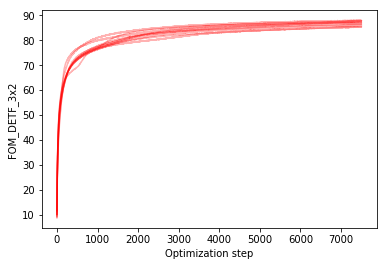

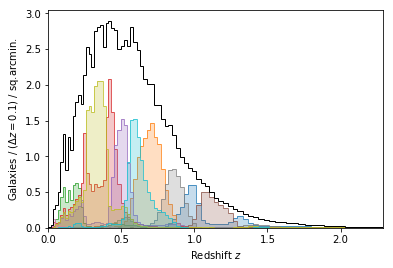

In [38]:
run_study('results/edm-300-detf', optimize_bins)

Running job with {'groups': 'group_emd_80_150', 'nbin': 2, 'ntrial': 10, 'nsteps': 1500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=18.912 (max=18.912) after 375 steps.
  score=19.846 (max=19.846) after 750 steps.
  score=20.112 (max=20.112) after 1125 steps.
  score=20.240 (max=20.241) after 1500 steps.
trial 1/10: score=20.240 (max=20.241) after 1500 steps.
  score=18.660 (max=20.241) after 375 steps.
  score=19.697 (max=20.241) after 750 steps.
  score=20.038 (max=20.241) after 1125 steps.
  score=20.170 (max=20.241) after 1500 steps.
trial 2/10: score=20.170 (max=20.241) after 1500 steps.
  score=18.688 (max=20.241) after 375 steps.
  score=19.695 (max=20.241) after 750 steps.
  score=20.051 (max=20.241) after 1125 steps.
  score=20.170 (max=20.241) after 1500 steps.
trial 3/10: score=20.170 (max=20.241) after 1500 steps.
  score=18.411 (max=20.241) after 375 steps.
  score=19.536 (max=20.241) after 750 steps.
  score=19.980 

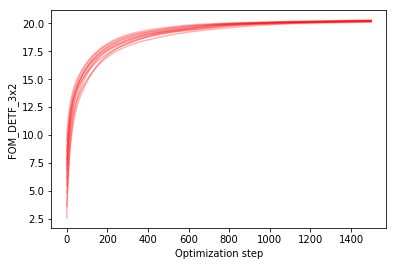

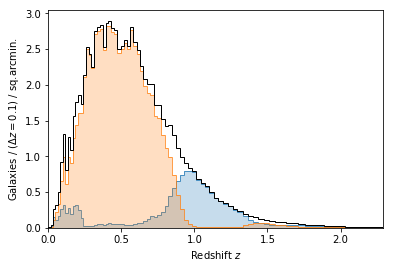

Running job with {'groups': 'group_emd_80_150', 'nbin': 4, 'ntrial': 10, 'nsteps': 3000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=49.656 (max=49.657) after 750 steps.
  score=51.712 (max=51.712) after 1500 steps.
  score=52.510 (max=52.513) after 2250 steps.
  score=53.238 (max=53.240) after 3000 steps.
trial 1/10: score=53.238 (max=53.240) after 3000 steps.
  score=52.426 (max=53.240) after 750 steps.
  score=53.688 (max=53.696) after 1500 steps.
  score=54.145 (max=54.147) after 2250 steps.
  score=54.365 (max=54.367) after 3000 steps.
trial 2/10: score=54.365 (max=54.367) after 3000 steps.
  score=49.246 (max=54.367) after 750 steps.
  score=51.540 (max=54.367) after 1500 steps.
  score=52.777 (max=54.367) after 2250 steps.
  score=54.332 (max=54.367) after 3000 steps.
trial 3/10: score=54.332 (max=54.367) after 3000 steps.
  score=51.126 (max=54.367) after 750 steps.
  score=53.829 (max=54.367) after 1500 steps.
  score=54.

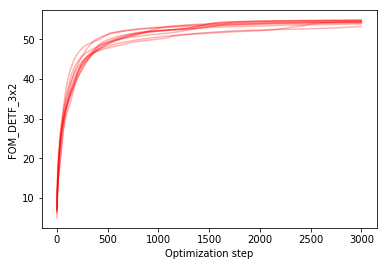

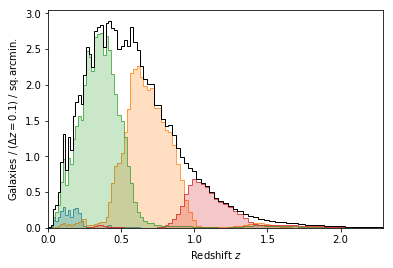

Running job with {'groups': 'group_emd_80_150', 'nbin': 6, 'ntrial': 10, 'nsteps': 4500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=65.338 (max=65.345) after 1125 steps.
  score=66.816 (max=66.816) after 2250 steps.
  score=67.453 (max=67.453) after 3375 steps.
  score=67.781 (max=67.798) after 4500 steps.
trial 1/10: score=67.781 (max=67.798) after 4500 steps.
  score=65.428 (max=67.798) after 1125 steps.
  score=66.856 (max=67.798) after 2250 steps.
  score=67.475 (max=67.798) after 3375 steps.
  score=67.871 (max=67.877) after 4500 steps.
trial 2/10: score=67.871 (max=67.877) after 4500 steps.
  score=65.787 (max=67.877) after 1125 steps.
  score=67.421 (max=67.877) after 2250 steps.
  score=67.858 (max=67.882) after 3375 steps.
  score=68.245 (max=68.257) after 4500 steps.
trial 3/10: score=68.245 (max=68.257) after 4500 steps.
  score=64.001 (max=68.257) after 1125 steps.
  score=66.737 (max=68.257) after 2250 steps.
  score

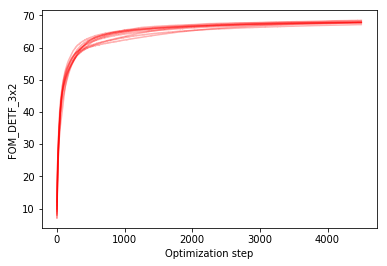

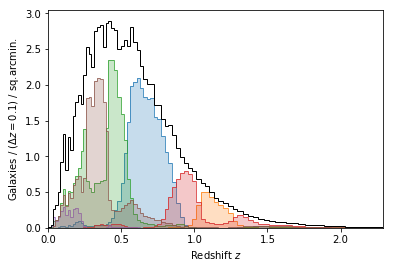

Running job with {'groups': 'group_emd_80_150', 'nbin': 8, 'ntrial': 10, 'nsteps': 6000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=71.000 (max=71.053) after 1500 steps.
  score=73.854 (max=73.865) after 3000 steps.
  score=75.633 (max=75.649) after 4500 steps.
  score=76.310 (max=76.352) after 6000 steps.
trial 1/10: score=76.310 (max=76.352) after 6000 steps.
  score=75.798 (max=76.352) after 1500 steps.
  score=77.366 (max=77.458) after 3000 steps.
  score=77.988 (max=78.132) after 4500 steps.
  score=78.784 (max=78.993) after 6000 steps.
trial 2/10: score=78.784 (max=78.993) after 6000 steps.
  score=73.588 (max=78.993) after 1500 steps.
  score=76.105 (max=78.993) after 3000 steps.
  score=76.865 (max=78.993) after 4500 steps.
  score=77.243 (max=78.993) after 6000 steps.
trial 3/10: score=77.243 (max=78.993) after 6000 steps.
  score=75.180 (max=78.993) after 1500 steps.
  score=77.113 (max=78.993) after 3000 steps.
  score

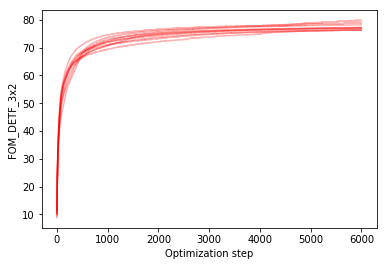

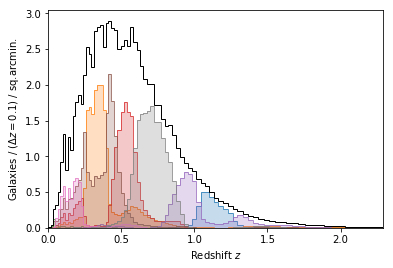

Running job with {'groups': 'group_emd_80_150', 'nbin': 10, 'ntrial': 10, 'nsteps': 7500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=80.462 (max=80.642) after 1875 steps.
  score=83.813 (max=84.048) after 3750 steps.
  score=85.579 (max=85.579) after 5625 steps.
  score=86.167 (max=86.279) after 7500 steps.
trial 1/10: score=86.167 (max=86.279) after 7500 steps.
  score=81.119 (max=86.279) after 1875 steps.
  score=83.277 (max=86.279) after 3750 steps.
  score=84.266 (max=86.279) after 5625 steps.
  score=84.842 (max=86.279) after 7500 steps.
trial 2/10: score=84.842 (max=86.279) after 7500 steps.
  score=79.266 (max=86.279) after 1875 steps.
  score=80.829 (max=86.279) after 3750 steps.
  score=82.854 (max=86.279) after 5625 steps.
  score=85.485 (max=86.279) after 7500 steps.
trial 3/10: score=85.485 (max=86.279) after 7500 steps.
  score=83.282 (max=86.279) after 1875 steps.
  score=85.747 (max=86.279) after 3750 steps.
  scor

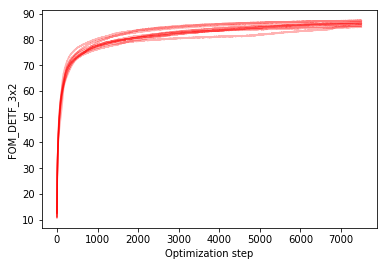

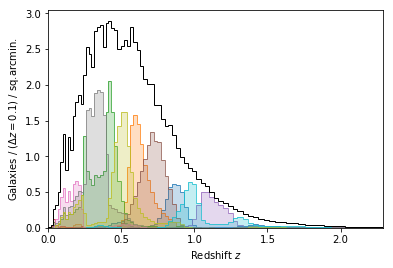

In [39]:
run_study('results/edm-150-detf', optimize_bins)

Skipping already completed job for nbin=2
Starting job at 2020-09-14 06:07:12.579171 with {'groups': 'group_cos_80_150', 'nbin': 3, 'ntrial': 10, 'nsteps': 2500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=34.960 (max=34.960) after 625 steps.
  score=36.236 (max=36.236) after 1250 steps.
  score=36.712 (max=36.714) after 1875 steps.
  score=37.389 (max=37.389) after 2500 steps.
trial 1/10: score=37.389 (max=37.389) after 2500 steps.
  score=36.255 (max=37.389) after 625 steps.
  score=39.565 (max=39.565) after 1250 steps.
  score=39.979 (max=39.980) after 1875 steps.
  score=40.076 (max=40.076) after 2500 steps.
trial 2/10: score=40.076 (max=40.076) after 2500 steps.
  score=36.145 (max=40.076) after 625 steps.
  score=39.563 (max=40.076) after 1250 steps.
  score=39.974 (max=40.076) after 1875 steps.
  score=40.070 (max=40.076) after 2500 steps.
trial 3/10: score=40.070 (max=40.076) after 2500 steps.
  score=36.608 (max=40.076) a

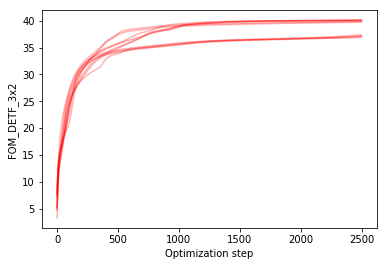

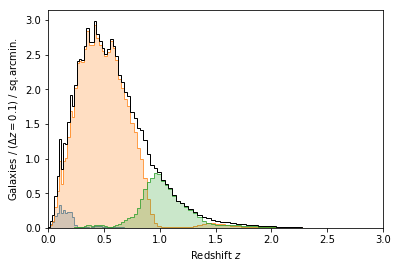

Skipping already completed job for nbin=4
Skipping already completed job for nbin=6
Skipping already completed job for nbin=8
Skipping already completed job for nbin=10


In [24]:
run_study('results/cos-150-detf', optimize_bins)

Skipping already completed job for nbin=2
Starting job at 2020-09-14 06:09:17.721322 with {'groups': 'group_cos_150_dc2', 'nbin': 3, 'ntrial': 10, 'nsteps': 2500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=55.417 (max=55.417) after 625 steps.
  score=61.255 (max=61.255) after 1250 steps.
  score=62.884 (max=62.887) after 1875 steps.
  score=63.993 (max=63.993) after 2500 steps.
trial 1/10: score=63.993 (max=63.993) after 2500 steps.
  score=60.770 (max=63.993) after 625 steps.
  score=63.110 (max=63.993) after 1250 steps.
  score=70.635 (max=70.635) after 1875 steps.
  score=70.801 (max=70.810) after 2500 steps.
trial 2/10: score=70.801 (max=70.810) after 2500 steps.
  score=60.390 (max=70.810) after 625 steps.
  score=63.158 (max=70.810) after 1250 steps.
  score=69.742 (max=70.810) after 1875 steps.
  score=70.778 (max=70.810) after 2500 steps.
trial 3/10: score=70.778 (max=70.810) after 2500 steps.
  score=58.633 (max=70.810) 

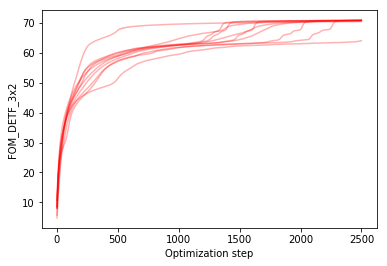

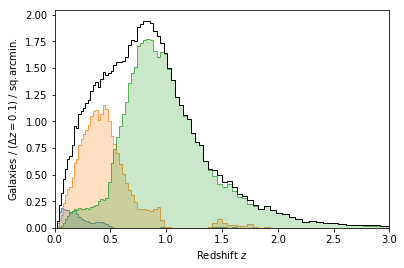

Skipping already completed job for nbin=4
Skipping already completed job for nbin=6
Skipping already completed job for nbin=8
Skipping already completed job for nbin=10


In [25]:
run_study('results/cos-150-detf-dc2', optimize_bins)

Skipping already completed job for nbin=2
Starting job at 2020-09-14 06:11:15.264179 with {'groups': 'group_cos_150_dc2', 'nbin': 3, 'ntrial': 10, 'nsteps': 2500, 'eta': 0.02, 'transform': 'extend', 'metric': 'SNR_3x2', 'method': 'jax', 'seed': 123}
  score=1070.369 (max=1070.369) after 625 steps.
  score=1077.144 (max=1077.144) after 1250 steps.
  score=1079.036 (max=1079.036) after 1875 steps.
  score=1080.481 (max=1080.483) after 2500 steps.
trial 1/10: score=1080.481 (max=1080.483) after 2500 steps.
  score=1091.112 (max=1091.112) after 625 steps.
  score=1096.896 (max=1096.896) after 1250 steps.
  score=1098.560 (max=1098.560) after 1875 steps.
  score=1099.296 (max=1099.296) after 2500 steps.
trial 2/10: score=1099.296 (max=1099.296) after 2500 steps.
  score=1087.216 (max=1099.296) after 625 steps.
  score=1095.106 (max=1099.296) after 1250 steps.
  score=1097.051 (max=1099.296) after 1875 steps.
  score=1097.852 (max=1099.296) after 2500 steps.
trial 3/10: score=1097.852 (max=1

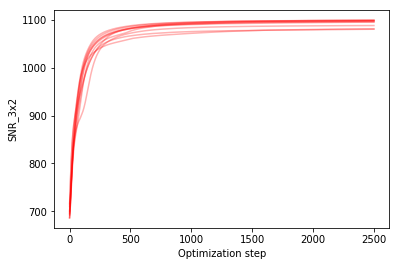

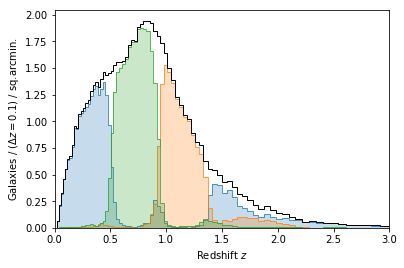

Skipping already completed job for nbin=4
Skipping already completed job for nbin=6
Skipping already completed job for nbin=8
Skipping already completed job for nbin=10


In [26]:
run_study('results/cos-150-snr-dc2', optimize_bins)

Skipping already completed job for nbin=2
Starting job at 2020-09-14 06:12:49.765007 with {'groups': 'group_cos_150_dc2', 'nbin': 3, 'ntrial': 10, 'nsteps': 2500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_3x2', 'method': 'jax', 'seed': 123}
  score=2675.871 (max=2675.871) after 625 steps.
  score=2769.024 (max=2769.024) after 1250 steps.
  score=2806.969 (max=2807.027) after 1875 steps.
  score=2822.141 (max=2822.141) after 2500 steps.
trial 1/10: score=2822.141 (max=2822.141) after 2500 steps.
  score=2694.040 (max=2822.141) after 625 steps.
  score=2741.871 (max=2822.141) after 1250 steps.
  score=2752.780 (max=2822.141) after 1875 steps.
  score=2757.420 (max=2822.141) after 2500 steps.
trial 2/10: score=2757.420 (max=2822.141) after 2500 steps.
  score=2474.764 (max=2822.141) after 625 steps.
  score=2664.563 (max=2822.141) after 1250 steps.
  score=2740.730 (max=2822.141) after 1875 steps.
  score=2815.555 (max=2822.141) after 2500 steps.
trial 3/10: score=2815.555 (max=2

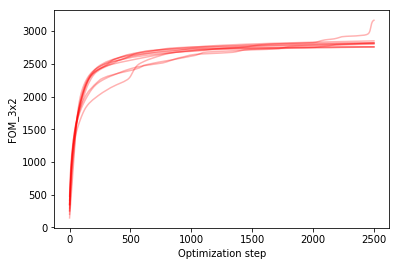

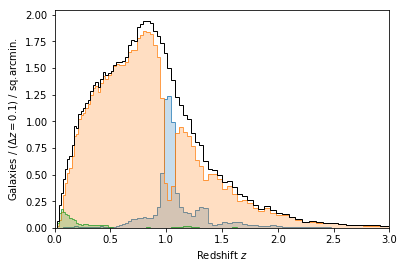

Skipping already completed job for nbin=4
Skipping already completed job for nbin=6
Skipping already completed job for nbin=8
Skipping already completed job for nbin=10


In [27]:
run_study('results/cos-150-fom-dc2', optimize_bins)

Starting job at 2020-09-12 20:42:15.759917 with {'groups': 'group_cos_15pct_150', 'nbin': 2, 'ntrial': 10, 'nsteps': 1500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=18.876 (max=18.876) after 375 steps.
  score=19.852 (max=19.852) after 750 steps.
  score=20.178 (max=20.179) after 1125 steps.
  score=20.288 (max=20.288) after 1500 steps.
trial 1/10: score=20.288 (max=20.288) after 1500 steps.
  score=19.056 (max=20.288) after 375 steps.
  score=19.900 (max=20.288) after 750 steps.
  score=20.197 (max=20.288) after 1125 steps.
  score=20.298 (max=20.299) after 1500 steps.
trial 2/10: score=20.298 (max=20.299) after 1500 steps.
  score=18.679 (max=20.299) after 375 steps.
  score=19.723 (max=20.299) after 750 steps.
  score=20.106 (max=20.299) after 1125 steps.
  score=20.224 (max=20.299) after 1500 steps.
trial 3/10: score=20.224 (max=20.299) after 1500 steps.
  score=18.836 (max=20.299) after 375 steps.
  score=19.811 (max=20.299

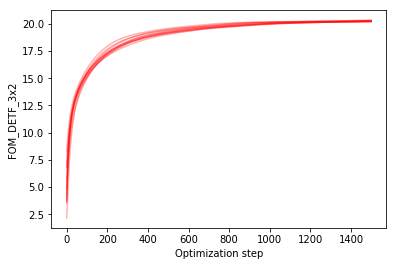

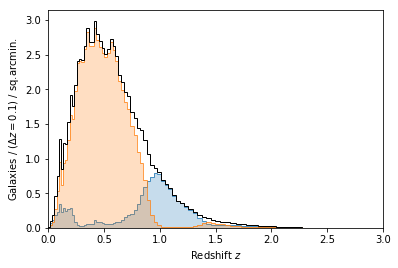

Starting job at 2020-09-12 20:43:27.313163 with {'groups': 'group_cos_15pct_150', 'nbin': 4, 'ntrial': 10, 'nsteps': 3000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=52.198 (max=52.198) after 750 steps.
  score=54.469 (max=54.472) after 1500 steps.
  score=54.839 (max=54.842) after 2250 steps.
  score=55.052 (max=55.053) after 3000 steps.
trial 1/10: score=55.052 (max=55.053) after 3000 steps.
  score=51.944 (max=55.053) after 750 steps.
  score=54.303 (max=55.053) after 1500 steps.
  score=54.806 (max=55.053) after 2250 steps.
  score=54.992 (max=55.053) after 3000 steps.
trial 2/10: score=54.992 (max=55.053) after 3000 steps.
  score=51.951 (max=55.053) after 750 steps.
  score=54.826 (max=55.053) after 1500 steps.
  score=55.173 (max=55.174) after 2250 steps.
  score=55.289 (max=55.291) after 3000 steps.
trial 3/10: score=55.289 (max=55.291) after 3000 steps.
  score=52.806 (max=55.291) after 750 steps.
  score=53.943 (max=55.

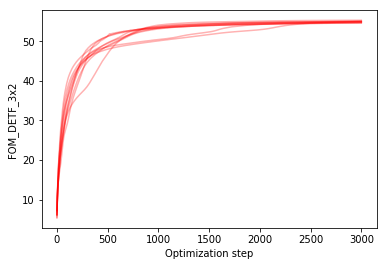

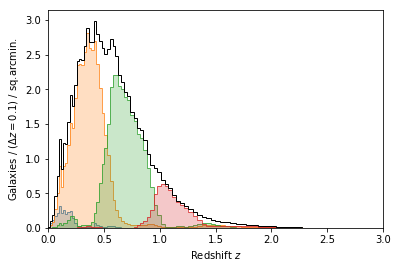

Starting job at 2020-09-12 20:47:37.104426 with {'groups': 'group_cos_15pct_150', 'nbin': 6, 'ntrial': 10, 'nsteps': 4500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=64.790 (max=64.790) after 1125 steps.
  score=66.557 (max=66.557) after 2250 steps.
  score=67.428 (max=67.428) after 3375 steps.
  score=67.957 (max=67.964) after 4500 steps.
trial 1/10: score=67.957 (max=67.964) after 4500 steps.
  score=66.182 (max=67.964) after 1125 steps.
  score=68.001 (max=68.022) after 2250 steps.
  score=68.711 (max=68.712) after 3375 steps.
  score=69.029 (max=69.029) after 4500 steps.
trial 2/10: score=69.029 (max=69.029) after 4500 steps.
  score=65.861 (max=69.029) after 1125 steps.
  score=67.455 (max=69.029) after 2250 steps.
  score=68.069 (max=69.029) after 3375 steps.
  score=68.449 (max=69.029) after 4500 steps.
trial 3/10: score=68.449 (max=69.029) after 4500 steps.
  score=62.866 (max=69.029) after 1125 steps.
  score=65.733 (max

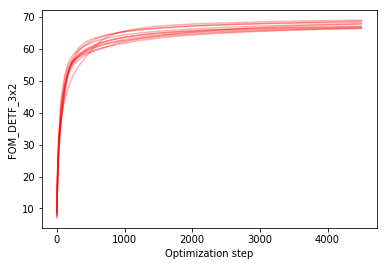

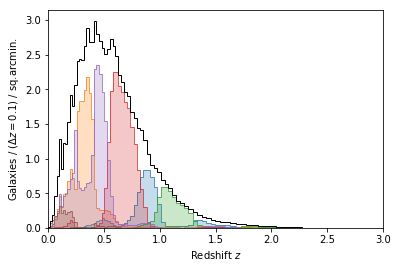

Starting job at 2020-09-12 21:01:21.382763 with {'groups': 'group_cos_15pct_150', 'nbin': 8, 'ntrial': 10, 'nsteps': 6000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=75.279 (max=75.279) after 1500 steps.
  score=77.772 (max=77.786) after 3000 steps.
  score=78.701 (max=78.710) after 4500 steps.
  score=79.130 (max=79.144) after 6000 steps.
trial 1/10: score=79.130 (max=79.144) after 6000 steps.
  score=73.561 (max=79.144) after 1500 steps.
  score=75.459 (max=79.144) after 3000 steps.
  score=76.222 (max=79.144) after 4500 steps.
  score=76.640 (max=79.144) after 6000 steps.
trial 2/10: score=76.640 (max=79.144) after 6000 steps.
  score=74.006 (max=79.144) after 1500 steps.
  score=77.370 (max=79.144) after 3000 steps.
  score=78.464 (max=79.144) after 4500 steps.
  score=78.962 (max=79.144) after 6000 steps.
trial 3/10: score=78.962 (max=79.144) after 6000 steps.
  score=76.379 (max=79.144) after 1500 steps.
  score=78.351 (max

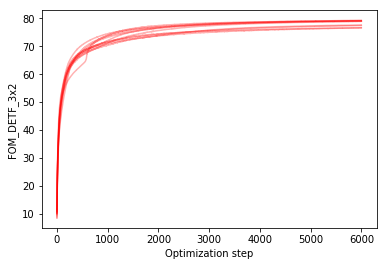

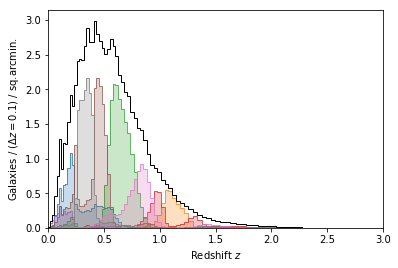

Starting job at 2020-09-12 21:25:16.313741 with {'groups': 'group_cos_15pct_150', 'nbin': 10, 'ntrial': 10, 'nsteps': 7500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=81.827 (max=81.843) after 1875 steps.
  score=85.498 (max=85.514) after 3750 steps.
  score=86.642 (max=86.677) after 5625 steps.
  score=87.139 (max=87.169) after 7500 steps.
trial 1/10: score=87.139 (max=87.169) after 7500 steps.
  score=82.144 (max=87.169) after 1875 steps.
  score=84.990 (max=87.169) after 3750 steps.
  score=86.132 (max=87.169) after 5625 steps.
  score=86.766 (max=87.169) after 7500 steps.
trial 2/10: score=86.766 (max=87.169) after 7500 steps.
  score=82.470 (max=87.169) after 1875 steps.
  score=86.450 (max=87.169) after 3750 steps.
  score=87.493 (max=87.501) after 5625 steps.
  score=87.787 (max=87.806) after 7500 steps.
trial 3/10: score=87.787 (max=87.806) after 7500 steps.
  score=81.353 (max=87.806) after 1875 steps.
  score=84.271 (ma

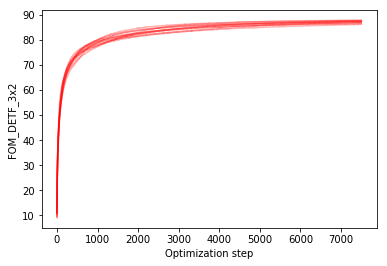

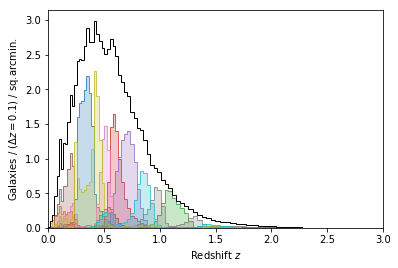

In [26]:
run_study('results/cos-15pct-150-detf', optimize_bins)

Running job with {'groups': 'group_wgt_80_150', 'nbin': 2, 'ntrial': 10, 'nsteps': 1500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=18.402 (max=18.402) after 375 steps.
  score=19.546 (max=19.546) after 750 steps.
  score=19.872 (max=19.874) after 1125 steps.
  score=20.003 (max=20.003) after 1500 steps.
trial 1/10: score=20.003 (max=20.003) after 1500 steps.
  score=18.531 (max=20.003) after 375 steps.
  score=19.533 (max=20.003) after 750 steps.
  score=19.868 (max=20.003) after 1125 steps.
  score=20.011 (max=20.012) after 1500 steps.
trial 2/10: score=20.011 (max=20.012) after 1500 steps.
  score=18.505 (max=20.012) after 375 steps.
  score=19.521 (max=20.012) after 750 steps.
  score=19.878 (max=20.012) after 1125 steps.
  score=20.002 (max=20.012) after 1500 steps.
trial 3/10: score=20.002 (max=20.012) after 1500 steps.
  score=19.064 (max=20.012) after 375 steps.
  score=19.803 (max=20.012) after 750 steps.
  score=20.013 

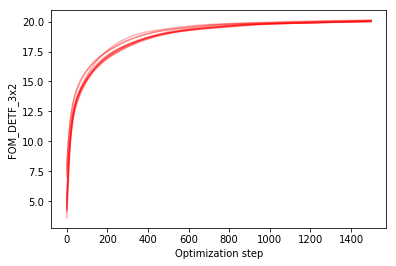

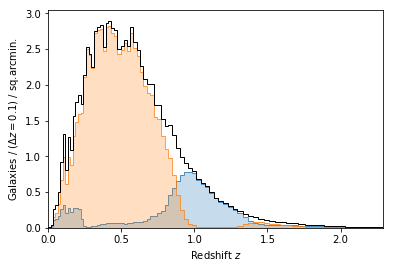

Running job with {'groups': 'group_wgt_80_150', 'nbin': 4, 'ntrial': 10, 'nsteps': 3000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=48.263 (max=48.263) after 750 steps.
  score=49.613 (max=49.613) after 1500 steps.
  score=50.279 (max=50.286) after 2250 steps.
  score=50.870 (max=50.870) after 3000 steps.
trial 1/10: score=50.870 (max=50.870) after 3000 steps.
  score=52.572 (max=52.584) after 750 steps.
  score=53.276 (max=53.294) after 1500 steps.
  score=53.569 (max=53.571) after 2250 steps.
  score=53.723 (max=53.738) after 3000 steps.
trial 2/10: score=53.723 (max=53.738) after 3000 steps.
  score=49.665 (max=53.738) after 750 steps.
  score=53.589 (max=53.738) after 1500 steps.
  score=54.008 (max=54.009) after 2250 steps.
  score=54.114 (max=54.116) after 3000 steps.
trial 3/10: score=54.114 (max=54.116) after 3000 steps.
  score=51.828 (max=54.116) after 750 steps.
  score=53.835 (max=54.116) after 1500 steps.
  score=54.

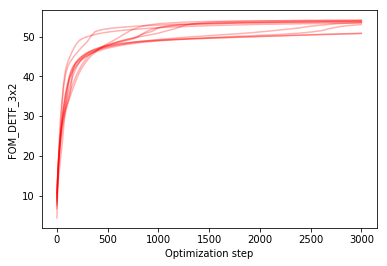

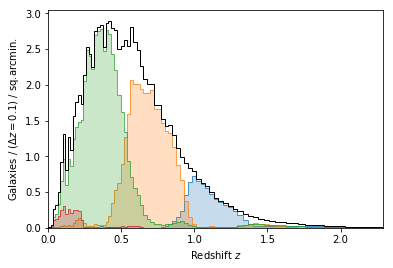

Running job with {'groups': 'group_wgt_80_150', 'nbin': 6, 'ntrial': 10, 'nsteps': 4500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=65.049 (max=65.049) after 1125 steps.
  score=66.773 (max=66.786) after 2250 steps.
  score=67.351 (max=67.356) after 3375 steps.
  score=67.618 (max=67.634) after 4500 steps.
trial 1/10: score=67.618 (max=67.634) after 4500 steps.
  score=64.364 (max=67.634) after 1125 steps.
  score=66.429 (max=67.634) after 2250 steps.
  score=67.114 (max=67.634) after 3375 steps.
  score=67.431 (max=67.634) after 4500 steps.
trial 2/10: score=67.431 (max=67.634) after 4500 steps.
  score=61.874 (max=67.634) after 1125 steps.
  score=64.269 (max=67.634) after 2250 steps.
  score=65.736 (max=67.634) after 3375 steps.
  score=66.597 (max=67.634) after 4500 steps.
trial 3/10: score=66.597 (max=67.634) after 4500 steps.
  score=64.591 (max=67.634) after 1125 steps.
  score=66.221 (max=67.634) after 2250 steps.
  score

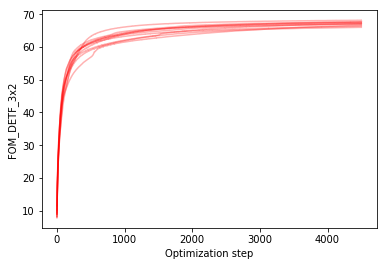

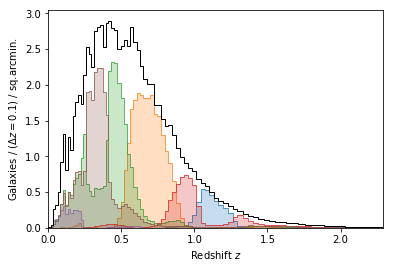

Running job with {'groups': 'group_wgt_80_150', 'nbin': 8, 'ntrial': 10, 'nsteps': 6000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=71.722 (max=71.722) after 1500 steps.
  score=73.336 (max=73.344) after 3000 steps.
  score=74.072 (max=74.111) after 4500 steps.
  score=74.589 (max=74.589) after 6000 steps.
trial 1/10: score=74.589 (max=74.589) after 6000 steps.
  score=73.902 (max=74.589) after 1500 steps.
  score=76.348 (max=76.368) after 3000 steps.
  score=77.171 (max=77.194) after 4500 steps.
  score=77.599 (max=77.613) after 6000 steps.
trial 2/10: score=77.599 (max=77.613) after 6000 steps.
  score=72.856 (max=77.613) after 1500 steps.
  score=74.885 (max=77.613) after 3000 steps.
  score=75.585 (max=77.613) after 4500 steps.
  score=76.051 (max=77.613) after 6000 steps.
trial 3/10: score=76.051 (max=77.613) after 6000 steps.
  score=72.313 (max=77.613) after 1500 steps.
  score=73.915 (max=77.613) after 3000 steps.
  score

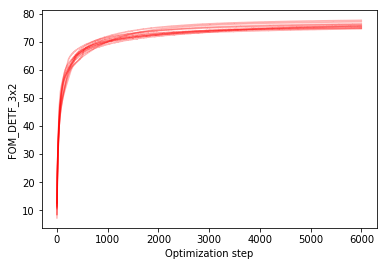

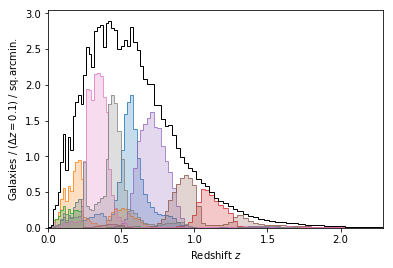

Running job with {'groups': 'group_wgt_80_150', 'nbin': 10, 'ntrial': 10, 'nsteps': 7500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=81.996 (max=82.047) after 1875 steps.
  score=84.960 (max=85.005) after 3750 steps.
  score=85.917 (max=85.922) after 5625 steps.
  score=86.372 (max=86.394) after 7500 steps.
trial 1/10: score=86.372 (max=86.394) after 7500 steps.
  score=80.694 (max=86.394) after 1875 steps.
  score=83.228 (max=86.394) after 3750 steps.
  score=84.197 (max=86.394) after 5625 steps.
  score=85.024 (max=86.394) after 7500 steps.
trial 2/10: score=85.024 (max=86.394) after 7500 steps.
  score=82.485 (max=86.394) after 1875 steps.
  score=85.197 (max=86.394) after 3750 steps.
  score=86.047 (max=86.394) after 5625 steps.
  score=86.446 (max=86.464) after 7500 steps.
trial 3/10: score=86.446 (max=86.464) after 7500 steps.
  score=78.802 (max=86.464) after 1875 steps.
  score=82.465 (max=86.464) after 3750 steps.
  scor

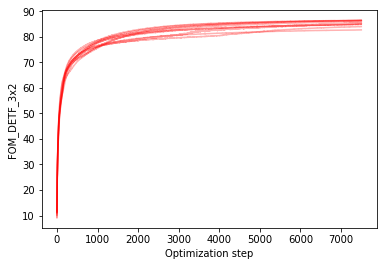

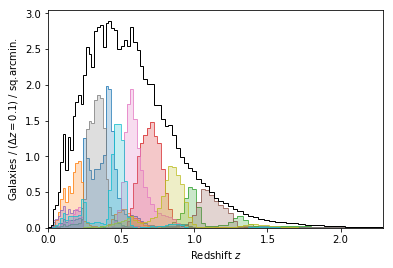

In [41]:
run_study('results/wgt-150-detf', optimize_bins)

Running job with {'groups': 'group_cos_80_75', 'nbin': 2, 'ntrial': 10, 'nsteps': 1500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=18.837 (max=18.837) after 375 steps.
  score=19.904 (max=19.904) after 750 steps.
  score=20.125 (max=20.126) after 1125 steps.
  score=20.206 (max=20.206) after 1500 steps.
trial 1/10: score=20.206 (max=20.206) after 1500 steps.
  score=18.540 (max=20.206) after 375 steps.
  score=19.696 (max=20.206) after 750 steps.
  score=20.059 (max=20.206) after 1125 steps.
  score=20.158 (max=20.206) after 1500 steps.
trial 2/10: score=20.158 (max=20.206) after 1500 steps.
  score=18.595 (max=20.206) after 375 steps.
  score=19.793 (max=20.206) after 750 steps.
  score=20.082 (max=20.206) after 1125 steps.
  score=20.170 (max=20.206) after 1500 steps.
trial 3/10: score=20.170 (max=20.206) after 1500 steps.
  score=19.154 (max=20.206) after 375 steps.
  score=20.005 (max=20.206) after 750 steps.
  score=20.154 (

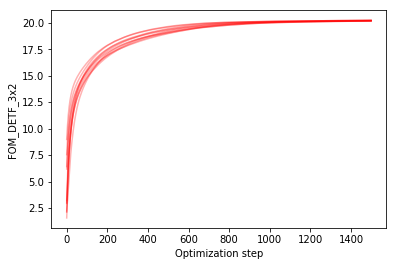

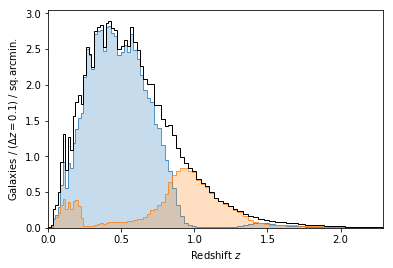

Running job with {'groups': 'group_cos_80_75', 'nbin': 4, 'ntrial': 10, 'nsteps': 3000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=51.999 (max=52.002) after 750 steps.
  score=53.417 (max=53.421) after 1500 steps.
  score=53.825 (max=53.831) after 2250 steps.
  score=53.999 (max=54.004) after 3000 steps.
trial 1/10: score=53.999 (max=54.004) after 3000 steps.
  score=49.796 (max=54.004) after 750 steps.
  score=52.933 (max=54.004) after 1500 steps.
  score=53.709 (max=54.004) after 2250 steps.
  score=53.950 (max=54.004) after 3000 steps.
trial 2/10: score=53.950 (max=54.004) after 3000 steps.
  score=52.369 (max=54.004) after 750 steps.
  score=53.338 (max=54.004) after 1500 steps.
  score=53.696 (max=54.004) after 2250 steps.
  score=53.875 (max=54.004) after 3000 steps.
trial 3/10: score=53.875 (max=54.004) after 3000 steps.
  score=51.628 (max=54.004) after 750 steps.
  score=53.171 (max=54.004) after 1500 steps.
  score=53.6

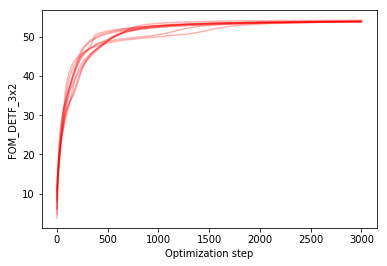

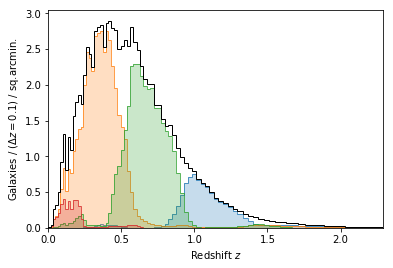

Running job with {'groups': 'group_cos_80_75', 'nbin': 6, 'ntrial': 10, 'nsteps': 4500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=60.567 (max=60.567) after 1125 steps.
  score=62.574 (max=62.576) after 2250 steps.
  score=64.163 (max=64.163) after 3375 steps.
  score=65.240 (max=65.255) after 4500 steps.
trial 1/10: score=65.240 (max=65.255) after 4500 steps.
  score=65.045 (max=65.255) after 1125 steps.
  score=66.686 (max=66.699) after 2250 steps.
  score=67.721 (max=67.740) after 3375 steps.
  score=68.211 (max=68.227) after 4500 steps.
trial 2/10: score=68.211 (max=68.227) after 4500 steps.
  score=63.491 (max=68.227) after 1125 steps.
  score=65.834 (max=68.227) after 2250 steps.
  score=66.708 (max=68.227) after 3375 steps.
  score=67.195 (max=68.227) after 4500 steps.
trial 3/10: score=67.195 (max=68.227) after 4500 steps.
  score=62.903 (max=68.227) after 1125 steps.
  score=65.343 (max=68.227) after 2250 steps.
  score=

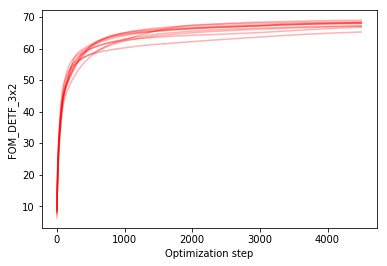

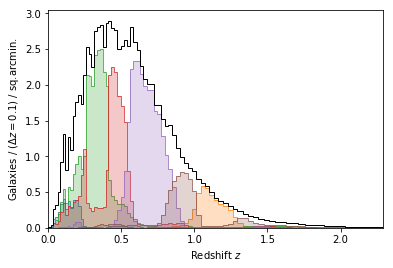

Running job with {'groups': 'group_cos_80_75', 'nbin': 8, 'ntrial': 10, 'nsteps': 6000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=75.163 (max=75.169) after 1500 steps.
  score=76.981 (max=77.024) after 3000 steps.
  score=77.654 (max=77.666) after 4500 steps.
  score=78.023 (max=78.037) after 6000 steps.
trial 1/10: score=78.023 (max=78.037) after 6000 steps.
  score=73.759 (max=78.037) after 1500 steps.
  score=75.640 (max=78.037) after 3000 steps.
  score=76.190 (max=78.037) after 4500 steps.
  score=76.469 (max=78.037) after 6000 steps.
trial 2/10: score=76.469 (max=78.037) after 6000 steps.
  score=75.780 (max=78.037) after 1500 steps.
  score=77.909 (max=78.037) after 3000 steps.
  score=78.883 (max=78.940) after 4500 steps.
  score=79.455 (max=79.536) after 6000 steps.
trial 3/10: score=79.455 (max=79.536) after 6000 steps.
  score=72.071 (max=79.536) after 1500 steps.
  score=74.680 (max=79.536) after 3000 steps.
  score=

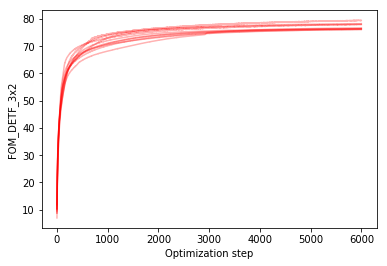

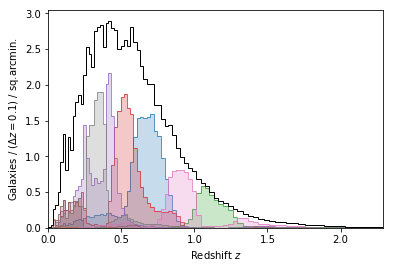

Running job with {'groups': 'group_cos_80_75', 'nbin': 10, 'ntrial': 10, 'nsteps': 7500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=83.848 (max=83.872) after 1875 steps.
  score=85.905 (max=85.920) after 3750 steps.
  score=86.572 (max=86.575) after 5625 steps.
  score=86.863 (max=86.886) after 7500 steps.
trial 1/10: score=86.863 (max=86.886) after 7500 steps.
  score=81.477 (max=86.886) after 1875 steps.
  score=83.910 (max=86.886) after 3750 steps.
  score=85.015 (max=86.886) after 5625 steps.
  score=85.649 (max=86.886) after 7500 steps.
trial 2/10: score=85.649 (max=86.886) after 7500 steps.
  score=81.270 (max=86.886) after 1875 steps.
  score=84.719 (max=86.886) after 3750 steps.
  score=86.242 (max=86.886) after 5625 steps.
  score=86.912 (max=86.943) after 7500 steps.
trial 3/10: score=86.912 (max=86.943) after 7500 steps.
  score=79.942 (max=86.943) after 1875 steps.
  score=83.186 (max=86.943) after 3750 steps.
  score

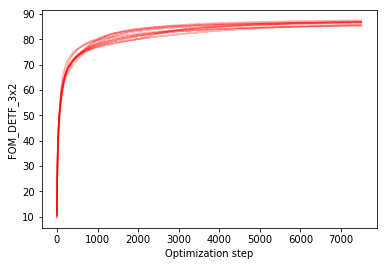

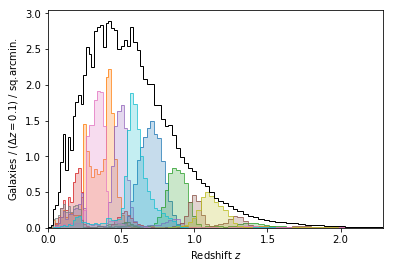

In [42]:
run_study('results/cos-75-detf', optimize_bins)

Skipping already completed job for nbin=2
Starting job at 2020-09-14 06:14:49.020359 with {'groups': 'group_cos_80_150', 'nbin': 3, 'ntrial': 10, 'nsteps': 2500, 'eta': 0.02, 'transform': 'extend', 'metric': 'SNR_3x2', 'method': 'jax', 'seed': 123}
  score=1138.884 (max=1138.884) after 625 steps.
  score=1147.120 (max=1147.120) after 1250 steps.
  score=1150.432 (max=1150.432) after 1875 steps.
  score=1151.304 (max=1151.304) after 2500 steps.
trial 1/10: score=1151.304 (max=1151.304) after 2500 steps.
  score=1144.210 (max=1151.304) after 625 steps.
  score=1150.673 (max=1151.304) after 1250 steps.
  score=1152.581 (max=1152.581) after 1875 steps.
  score=1153.423 (max=1153.423) after 2500 steps.
trial 2/10: score=1153.423 (max=1153.423) after 2500 steps.
  score=1138.441 (max=1153.423) after 625 steps.
  score=1144.824 (max=1153.423) after 1250 steps.
  score=1146.621 (max=1153.423) after 1875 steps.
  score=1147.586 (max=1153.423) after 2500 steps.
trial 3/10: score=1147.586 (max=11

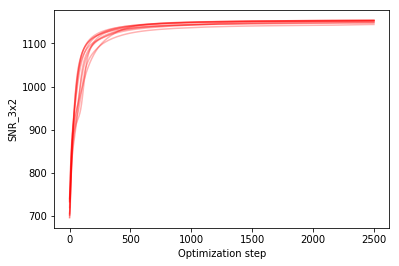

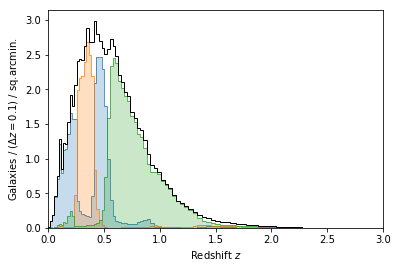

Skipping already completed job for nbin=4
Skipping already completed job for nbin=6
Skipping already completed job for nbin=8
Skipping already completed job for nbin=10


In [28]:
run_study('results/cos-150-snr', optimize_bins)

Skipping already completed job for nbin=2
Starting job at 2020-09-14 06:16:23.888929 with {'groups': 'group_cos_80_150', 'nbin': 3, 'ntrial': 10, 'nsteps': 2500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_3x2', 'method': 'jax', 'seed': 123}
  score=2139.890 (max=2139.890) after 625 steps.
  score=2314.228 (max=2314.228) after 1250 steps.
  score=2401.391 (max=2401.405) after 1875 steps.
  score=2422.169 (max=2422.238) after 2500 steps.
trial 1/10: score=2422.169 (max=2422.238) after 2500 steps.
  score=1717.857 (max=2422.238) after 625 steps.
  score=1785.021 (max=2422.238) after 1250 steps.
  score=1798.919 (max=2422.238) after 1875 steps.
  score=1816.887 (max=2422.238) after 2500 steps.
trial 2/10: score=1816.887 (max=2422.238) after 2500 steps.
  score=1870.866 (max=2422.238) after 625 steps.
  score=1973.074 (max=2422.238) after 1250 steps.
  score=1988.129 (max=2422.238) after 1875 steps.
  score=1998.082 (max=2422.238) after 2500 steps.
trial 3/10: score=1998.082 (max=24

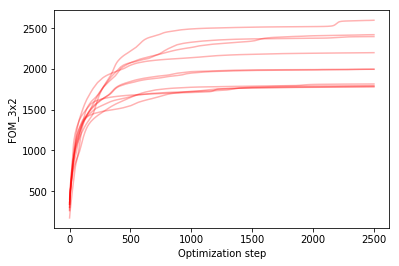

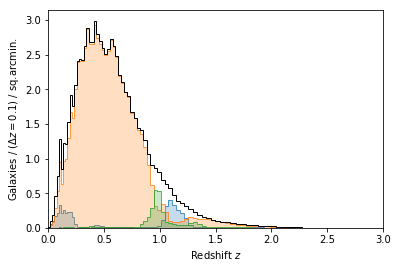

Skipping already completed job for nbin=4
Skipping already completed job for nbin=6
Skipping already completed job for nbin=8
Skipping already completed job for nbin=10


In [29]:
run_study('results/cos-150-fom', optimize_bins)

## Optimize Neural Network Classifier

Only load one of these if GPU memory is tight:

In [11]:
ndata = 2000000
with np.load('uniform_buz_riz.npz') as keys:
    Xbuz = jnp.array(3 * (keys['uniform'][:ndata] - 0.5))
    detected = keys['detected']
zbuz = jnp.array(load_redshift('/media/data2/tomo_challenge_data/ugrizy_buzzard/training.hdf5')[detected][:ndata])
print(f'Loaded {len(Xbuz)} Buzzard training samples with ~uniform distribution.')

Loaded 2000000 Buzzard training samples with ~uniform distribution.


In [41]:
del Xbuz, zbuz

In [42]:
ndata = 2000000
with np.load('uniform_dc2_riz.npz') as keys:
    Xdc2 = jnp.array(3 * (keys['uniform'][:ndata] - 0.5))
    detected = keys['detected']
zdc2 = jnp.array(load_redshift('/media/data2/tomo_challenge_data/ugrizy/training.hdf5')[detected][:ndata])
print(f'Loaded {len(Xdc2)} DC2 training samples with ~uniform distribution.')

Loaded 2000000 DC2 training samples with ~uniform distribution.


In [46]:
del Xdc2, zdc2

Learn a dense classifier using jax to build and optimize the network:

In [12]:
def learn_nnet(nbin=2, sample='buzzard', trainfrac=0.5, nhidden=64, nlayer=2, ntrial=1, nepoch=100, batchsize=50000, interval=10, eta=0.001,
               init_data=init_data, metric='FOM_DETF_3x2', gals_per_arcmin2=20., fsky=0.25, independent=False, seed=123):
    """
    """
    if sample == 'buzzard':
        X, z = Xbuz, zbuz
    elif sample == 'dc2':
        X, z = Xdc2, zdc2
    else:
        raise ValueError(f'Invalid sample: "{sample}".')
    zedges = np.array(init_data[0])
    # Include any overflow in the last bin.
    zedges[-1] = max(zedges[-1], z.max() + 1e-3)
    zedges = jnp.array(zedges)
    # Calculate the normalized dndz for each bin.
    def hist1bin(z, w):
        return jnp.histogram(z, bins=zedges, weights=w)[0]
    histbins = jax.vmap(hist1bin, in_axes=(None, 1), out_axes=0)
    
    # Build the network model.
    layers = []
    for i in range(nlayer):
        layers.extend([
            stax.Dense(nhidden),
            stax.LeakyRelu,
            stax.BatchNorm(axis=(0,1)),
        ])
    layers.extend([
        stax.Dense(nbin),
        stax.Softmax
    ])
    init_fun, apply_fun = stax.serial(*layers)

    def get_dndz(params, Xb, zb):
        # Get normalized weights from the network model.
        wgts = apply_fun(params, Xb)
        # Convert to a normalized dndz for each bin.
        w = histbins(zb, wgts)
        return w / zb.shape[0]        
    
    # Evaluate all 3x2 metrics.
    def metrics(params, Xb, zb):
        w = get_dndz(params, Xb, zb)
        # Use the same binning for number density and weak lensing.
        weights = jnp.array([w, w])
        return reweighted_metrics(weights, *init_data[1:], gals_per_arcmin2, fsky)
    
    # Evaluate the loss as -metric.
    def loss(params, Xb, zb):
        return -metrics(params, Xb, zb)[metric]
    
    opt_init, opt_update, get_params = optimizers.adam(eta)
    
    # Define the update rule.
    @jax.jit
    def update(i, opt_state, Xb, zb):
        params = get_params(opt_state)
        grads = jax.grad(loss)(params, Xb, zb)
        return opt_update(i, grads, opt_state)
    
    rng = jax.random.PRNGKey(seed)
    gen = np.random.RandomState(seed)
    
    ndata = X.shape[0]
    ntrain = int(np.round(ndata * trainfrac))
    Xtrain, ztrain = X[:ntrain], z[:ntrain]
    Xvalid, zvalid = X[ntrain:], z[ntrain:]
    nbatch = ntrain // batchsize
    
    all_scores = []
    max_score = -1
    best_params = None
    
    for trial in range(ntrial):
    
        _, init_params = init_fun(rng, (batchsize, X.shape[1]))
        opt_state = opt_init(init_params)

        all_scores.append([])
        itercount = itertools.count()
        for epoch in range(nepoch):
            perm = gen.permutation(ntrain)
            for batch in range(nbatch):
                idx = perm[batch * batchsize:(batch + 1) * batchsize]
                opt_state = update(next(itercount), opt_state, Xtrain[idx], ztrain[idx])
            # Calculate train and validation scores after this epoch.
            params = get_params(opt_state)
            train_score = metrics(params, Xtrain, ztrain)[metric]
            all_scores[-1].append(train_score)
            if train_score > max_score:
                best_params = params
                max_score = train_score
            if epoch % interval == 0:
                valid_score = metrics(params, Xvalid, zvalid)[metric]
                print(f'Trial {trial+1}/{ntrial} epoch {epoch+1}/{nepoch} train {train_score:.3f} (max {max_score:.3f}) validation {valid_score:.3f}.')

    # Calculate all metrics for the best params.
    best_scores = metrics(best_params, Xtrain, ztrain)
    best_scores = {metric: float(value) for metric, value in best_scores.items()}
    
    # Calculate the best weights.
    weights = apply_fun(best_params, Xtrain)
    
    # Convert the best parameters to normalized dndz weights.
    dndz_bin = get_dndz(best_params, Xtrain, ztrain)

    return best_scores, weights, dndz_bin, all_scores

In [13]:
run_study('results/nn-3-64-detf-gw', learn_nnet)

Starting job at 2020-09-14 15:45:18.184921 with {'sample': 'buzzard', 'independent': True, 'nbin': 2, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 3, 'nepoch': 200, 'eta': 0.001, 'metric': 'FOM_DETF_3x2', 'seed': 1}
Trial 1/3 epoch 1/200 train 19.398 (max 19.398) validation 19.422.


KeyboardInterrupt: 

Skipping already completed job for nbin=2
Starting job at 2020-09-14 07:04:29.853603 with {'sample': 'buzzard', 'nbin': 3, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 3, 'nepoch': 100, 'eta': 0.001, 'metric': 'FOM_DETF_3x2', 'seed': 1}
Trial 1/3 epoch 1/100 train 32.573 (max 32.573) validation 32.656.
Trial 1/3 epoch 11/100 train 41.060 (max 41.060) validation 41.272.
Trial 1/3 epoch 21/100 train 41.205 (max 41.367) validation 41.460.
Trial 1/3 epoch 31/100 train 41.311 (max 41.494) validation 41.424.
Trial 1/3 epoch 41/100 train 41.750 (max 41.789) validation 41.897.
Trial 1/3 epoch 51/100 train 41.961 (max 41.972) validation 41.971.
Trial 1/3 epoch 61/100 train 41.957 (max 42.049) validation 42.045.
Trial 1/3 epoch 71/100 train 42.051 (max 42.051) validation 42.183.
Trial 1/3 epoch 81/100 train 42.061 (max 42.112) validation 42.133.
Trial 1/3 epoch 91/100 train 41.954 (max 42.114) validation 41.977.
Trial 2/3 epoch 1/100 train 33.266 (max 42.144) valid

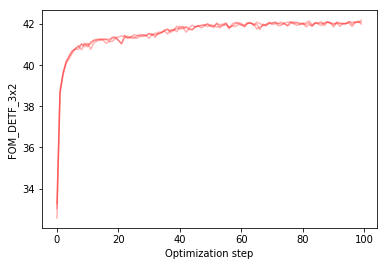

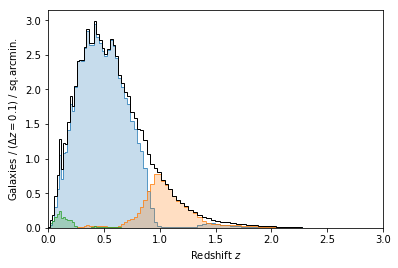

Skipping already completed job for nbin=4
Skipping already completed job for nbin=6
Skipping already completed job for nbin=8
Skipping already completed job for nbin=10


In [38]:
run_study('results/nn-3-64-detf', learn_nnet)

Skipping already completed job for nbin=2
Starting job at 2020-09-14 07:06:41.797368 with {'sample': 'buzzard', 'nbin': 3, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 3, 'nepoch': 100, 'eta': 0.001, 'metric': 'SNR_3x2', 'seed': 1}
Trial 1/3 epoch 1/100 train 1136.051 (max 1136.051) validation 1136.244.
Trial 1/3 epoch 11/100 train 1151.598 (max 1151.598) validation 1151.731.
Trial 1/3 epoch 21/100 train 1153.173 (max 1153.173) validation 1153.293.
Trial 1/3 epoch 31/100 train 1154.400 (max 1154.400) validation 1154.507.
Trial 1/3 epoch 41/100 train 1155.027 (max 1155.027) validation 1155.104.
Trial 1/3 epoch 51/100 train 1155.325 (max 1155.325) validation 1155.381.
Trial 1/3 epoch 61/100 train 1155.471 (max 1155.479) validation 1155.526.
Trial 1/3 epoch 71/100 train 1155.597 (max 1155.597) validation 1155.617.
Trial 1/3 epoch 81/100 train 1155.597 (max 1155.630) validation 1155.600.
Trial 1/3 epoch 91/100 train 1155.690 (max 1155.753) validation 1155.697

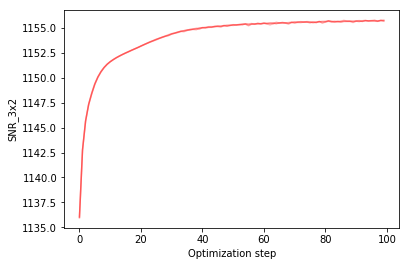

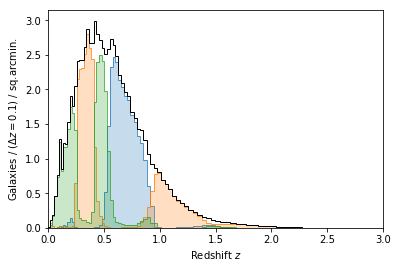

Skipping already completed job for nbin=4
Skipping already completed job for nbin=6
Skipping already completed job for nbin=8
Skipping already completed job for nbin=10


In [39]:
run_study('results/nn-3-64-snr', learn_nnet)

Skipping already completed job for nbin=2
Starting job at 2020-09-14 07:08:31.746125 with {'sample': 'buzzard', 'nbin': 3, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 3, 'nepoch': 100, 'eta': 0.001, 'metric': 'FOM_3x2', 'seed': 1}
Trial 1/3 epoch 1/100 train 2441.567 (max 2441.567) validation 2475.651.
Trial 1/3 epoch 11/100 train 3222.425 (max 3224.873) validation 3270.304.
Trial 1/3 epoch 21/100 train 3189.278 (max 3262.158) validation 3255.846.
Trial 1/3 epoch 31/100 train 3252.749 (max 3272.828) validation 3302.847.
Trial 1/3 epoch 41/100 train 3288.302 (max 3288.302) validation 3338.047.
Trial 1/3 epoch 51/100 train 3294.511 (max 3294.511) validation 3335.342.
Trial 1/3 epoch 61/100 train 3315.724 (max 3328.939) validation 3368.378.
Trial 1/3 epoch 71/100 train 3298.616 (max 3328.939) validation 3341.570.
Trial 1/3 epoch 81/100 train 3322.507 (max 3328.939) validation 3365.386.
Trial 1/3 epoch 91/100 train 3332.176 (max 3345.090) validation 3365.332

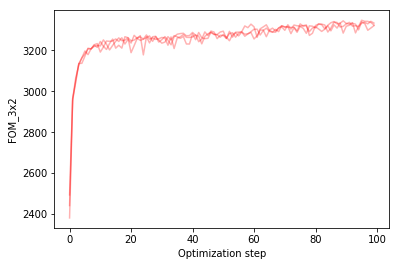

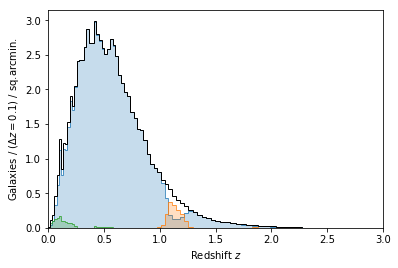

Skipping already completed job for nbin=4
Skipping already completed job for nbin=6
Skipping already completed job for nbin=8
Skipping already completed job for nbin=10


In [40]:
run_study('results/nn-3-64-fom', learn_nnet)

Skipping already completed job for nbin=2
Starting job at 2020-09-14 07:20:59.945364 with {'sample': 'dc2', 'nbin': 3, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 3, 'nepoch': 100, 'eta': 0.001, 'metric': 'FOM_DETF_3x2', 'seed': 1}
Trial 1/3 epoch 1/100 train 60.926 (max 60.926) validation 60.828.
Trial 1/3 epoch 11/100 train 74.956 (max 74.956) validation 74.665.
Trial 1/3 epoch 21/100 train 75.340 (max 75.340) validation 75.059.
Trial 1/3 epoch 31/100 train 75.435 (max 75.512) validation 75.110.
Trial 1/3 epoch 41/100 train 75.552 (max 75.557) validation 75.227.
Trial 1/3 epoch 51/100 train 75.519 (max 75.674) validation 75.112.
Trial 1/3 epoch 61/100 train 75.720 (max 75.720) validation 75.400.
Trial 1/3 epoch 71/100 train 75.531 (max 75.784) validation 75.284.
Trial 1/3 epoch 81/100 train 75.823 (max 75.823) validation 75.462.
Trial 1/3 epoch 91/100 train 75.849 (max 75.849) validation 75.543.
Trial 2/3 epoch 1/100 train 60.955 (max 75.866) validatio

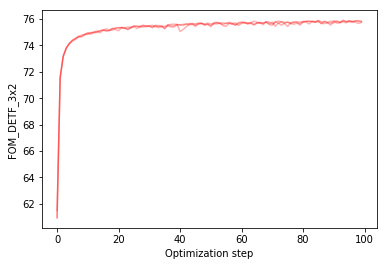

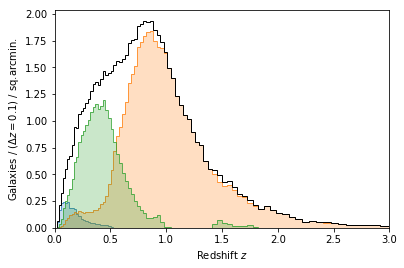

Skipping already completed job for nbin=4
Skipping already completed job for nbin=6
Skipping already completed job for nbin=8
Skipping already completed job for nbin=10


In [43]:
run_study('results/nn-3-64-detf-dc2', learn_nnet)

Skipping already completed job for nbin=2
Starting job at 2020-09-14 07:22:57.681510 with {'sample': 'dc2', 'nbin': 3, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 3, 'nepoch': 100, 'eta': 0.001, 'metric': 'SNR_3x2', 'seed': 1}
Trial 1/3 epoch 1/100 train 1082.026 (max 1082.026) validation 1082.266.
Trial 1/3 epoch 11/100 train 1100.121 (max 1100.121) validation 1100.302.
Trial 1/3 epoch 21/100 train 1102.572 (max 1102.572) validation 1102.727.
Trial 1/3 epoch 31/100 train 1103.657 (max 1103.657) validation 1103.804.
Trial 1/3 epoch 41/100 train 1104.077 (max 1104.105) validation 1104.191.
Trial 1/3 epoch 51/100 train 1104.600 (max 1104.708) validation 1104.659.
Trial 1/3 epoch 61/100 train 1104.920 (max 1105.023) validation 1105.061.
Trial 1/3 epoch 71/100 train 1105.035 (max 1105.306) validation 1105.080.
Trial 1/3 epoch 81/100 train 1105.330 (max 1105.367) validation 1105.373.
Trial 1/3 epoch 91/100 train 1105.415 (max 1105.421) validation 1105.426.
Tr

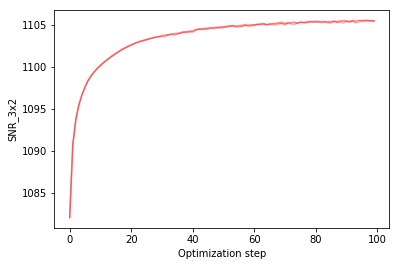

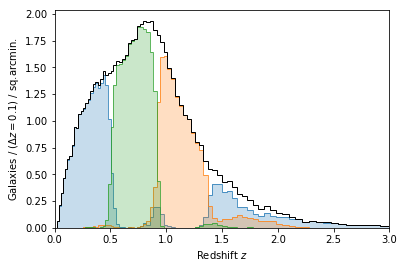

Skipping already completed job for nbin=4
Skipping already completed job for nbin=6
Skipping already completed job for nbin=8
Skipping already completed job for nbin=10


In [44]:
run_study('results/nn-3-64-snr-dc2', learn_nnet)

Skipping already completed job for nbin=2
Starting job at 2020-09-14 07:24:47.722401 with {'sample': 'dc2', 'nbin': 3, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 3, 'nepoch': 100, 'eta': 0.001, 'metric': 'FOM_3x2', 'seed': 1}
Trial 1/3 epoch 1/100 train 2986.974 (max 2986.974) validation 2970.991.
Trial 1/3 epoch 11/100 train 3976.835 (max 3976.835) validation 3963.447.
Trial 1/3 epoch 21/100 train 4007.800 (max 4007.800) validation 3991.189.
Trial 1/3 epoch 31/100 train 4018.478 (max 4019.958) validation 4004.297.
Trial 1/3 epoch 41/100 train 4012.309 (max 4026.484) validation 3993.954.
Trial 1/3 epoch 51/100 train 4025.064 (max 4032.279) validation 4006.665.
Trial 1/3 epoch 61/100 train 4033.275 (max 4035.845) validation 4013.250.
Trial 1/3 epoch 71/100 train 4037.920 (max 4037.920) validation 4018.313.
Trial 1/3 epoch 81/100 train 4032.487 (max 4043.944) validation 4018.436.
Trial 1/3 epoch 91/100 train 4057.639 (max 4060.256) validation 4031.610.
Tr

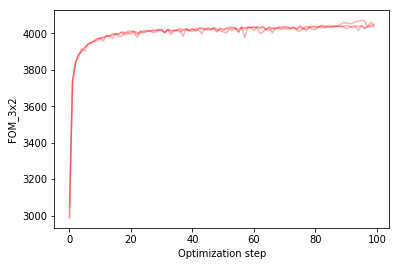

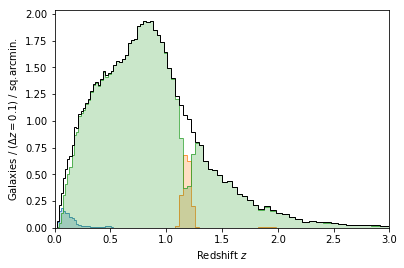

Skipping already completed job for nbin=4
Skipping already completed job for nbin=6
Skipping already completed job for nbin=8
Skipping already completed job for nbin=10


In [45]:
run_study('results/nn-3-64-fom-dc2', learn_nnet)

Skipping already completed job for nbin=2
Skipping already completed job for nbin=4
Starting job at 2020-09-11 14:47:58.476010 with {'nbin': 6, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 150, 'nlayer': 3, 'nepoch': 200, 'eta': 0.001, 'metric': 'FOM_DETF_3x2', 'seed': 1}
Trial 1/3 epoch 1/200 train 63.393 (max 63.393) validation 63.526.
Trial 1/3 epoch 11/200 train 71.397 (max 71.397) validation 71.440.
Trial 1/3 epoch 21/200 train 73.240 (max 73.240) validation 73.135.
Trial 1/3 epoch 31/200 train 73.761 (max 73.761) validation 73.742.
Trial 1/3 epoch 41/200 train 73.876 (max 73.948) validation 73.848.
Trial 1/3 epoch 51/200 train 73.916 (max 74.106) validation 73.909.
Trial 1/3 epoch 61/200 train 73.892 (max 74.160) validation 73.881.
Trial 1/3 epoch 71/200 train 74.085 (max 74.292) validation 73.967.
Trial 1/3 epoch 81/200 train 74.416 (max 74.478) validation 74.416.
Trial 1/3 epoch 91/200 train 74.620 (max 74.686) validation 74.578.
Trial 1/3 epoch 101/200 train 7

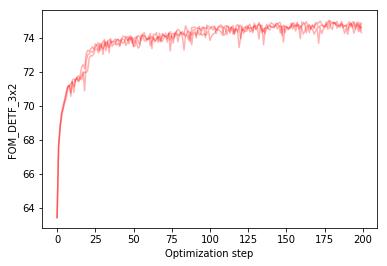

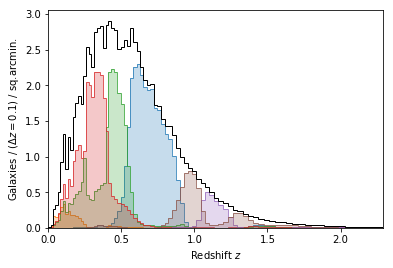

Starting job at 2020-09-11 14:58:20.382672 with {'nbin': 8, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 200, 'nlayer': 3, 'nepoch': 200, 'eta': 0.001, 'metric': 'FOM_DETF_3x2', 'seed': 1}
Trial 1/3 epoch 1/200 train 77.998 (max 77.998) validation 78.045.
Trial 1/3 epoch 11/200 train 83.989 (max 84.088) validation 84.053.
Trial 1/3 epoch 21/200 train 85.207 (max 85.207) validation 85.036.
Trial 1/3 epoch 31/200 train 85.564 (max 85.619) validation 85.445.
Trial 1/3 epoch 41/200 train 85.771 (max 85.924) validation 85.482.
Trial 1/3 epoch 51/200 train 86.158 (max 86.455) validation 86.029.
Trial 1/3 epoch 61/200 train 86.412 (max 86.539) validation 86.334.
Trial 1/3 epoch 71/200 train 86.575 (max 86.680) validation 86.583.
Trial 1/3 epoch 81/200 train 86.372 (max 86.680) validation 86.271.
Trial 1/3 epoch 91/200 train 86.706 (max 86.769) validation 86.594.
Trial 1/3 epoch 101/200 train 86.782 (max 86.784) validation 86.667.
Trial 1/3 epoch 111/200 train 86.574 (max 86.8

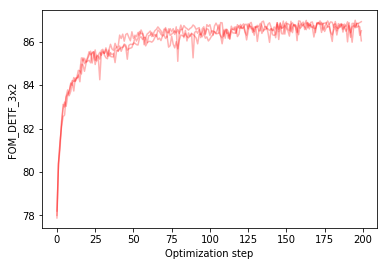

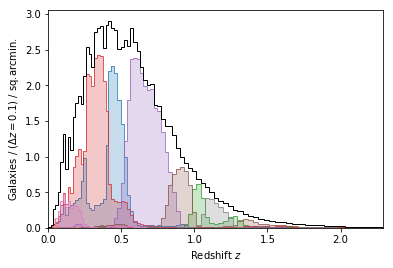

Starting job at 2020-09-11 15:11:39.733902 with {'nbin': 10, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 250, 'nlayer': 3, 'nepoch': 200, 'eta': 0.001, 'metric': 'FOM_DETF_3x2', 'seed': 1}
Trial 1/3 epoch 1/200 train 84.027 (max 84.027) validation 84.104.
Trial 1/3 epoch 11/200 train 94.238 (max 94.539) validation 94.506.
Trial 1/3 epoch 21/200 train 95.899 (max 96.360) validation 95.963.
Trial 1/3 epoch 31/200 train 96.806 (max 96.806) validation 96.950.
Trial 1/3 epoch 41/200 train 96.148 (max 97.194) validation 96.404.
Trial 1/3 epoch 51/200 train 97.020 (max 97.275) validation 97.052.
Trial 1/3 epoch 61/200 train 97.243 (max 97.455) validation 97.323.
Trial 1/3 epoch 71/200 train 96.953 (max 97.511) validation 96.858.
Trial 1/3 epoch 81/200 train 97.470 (max 97.511) validation 97.369.
Trial 1/3 epoch 91/200 train 97.364 (max 97.518) validation 97.385.
Trial 1/3 epoch 101/200 train 97.009 (max 97.552) validation 96.928.
Trial 1/3 epoch 111/200 train 97.680 (max 97.

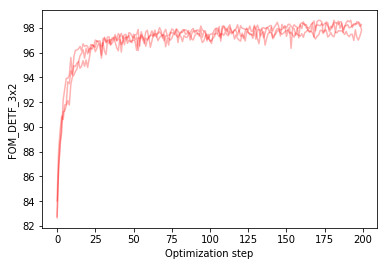

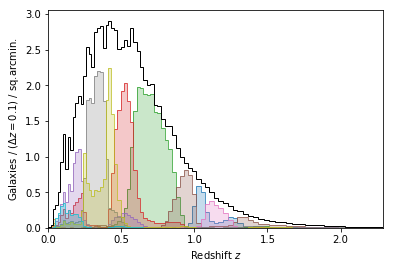

In [12]:
run_study('results/nn-3-detf', learn_nnet)

Starting job at 2020-09-11 16:16:09.533726 with {'nbin': 2, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 4, 'nepoch': 200, 'eta': 0.001, 'metric': 'FOM_DETF_3x2', 'seed': 1}
Trial 1/3 epoch 1/200 train 20.028 (max 20.028) validation 20.012.
Trial 1/3 epoch 11/200 train 20.672 (max 20.672) validation 20.644.
Trial 1/3 epoch 21/200 train 20.728 (max 20.728) validation 20.696.
Trial 1/3 epoch 31/200 train 20.703 (max 20.728) validation 20.670.
Trial 1/3 epoch 41/200 train 20.729 (max 20.757) validation 20.710.
Trial 1/3 epoch 51/200 train 20.870 (max 20.880) validation 20.814.
Trial 1/3 epoch 61/200 train 20.860 (max 20.910) validation 20.801.
Trial 1/3 epoch 71/200 train 20.917 (max 20.917) validation 20.858.
Trial 1/3 epoch 81/200 train 20.916 (max 20.923) validation 20.875.
Trial 1/3 epoch 91/200 train 20.882 (max 20.937) validation 20.812.
Trial 1/3 epoch 101/200 train 20.895 (max 20.937) validation 20.853.
Trial 1/3 epoch 111/200 train 20.910 (max 20.93

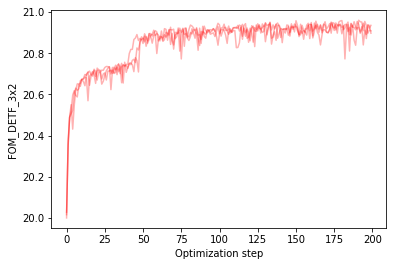

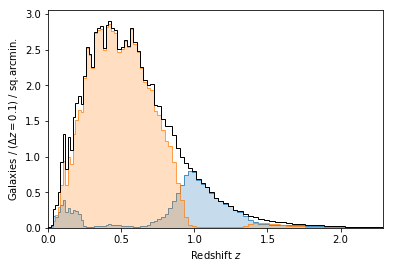

Starting job at 2020-09-11 16:20:07.058277 with {'nbin': 4, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 4, 'nepoch': 200, 'eta': 0.001, 'metric': 'FOM_DETF_3x2', 'seed': 1}
Trial 1/3 epoch 1/200 train 52.448 (max 52.448) validation 52.670.
Trial 1/3 epoch 11/200 train 57.097 (max 57.097) validation 57.134.
Trial 1/3 epoch 21/200 train 57.435 (max 57.459) validation 57.397.
Trial 1/3 epoch 31/200 train 58.125 (max 58.125) validation 58.010.
Trial 1/3 epoch 41/200 train 58.190 (max 58.190) validation 58.228.
Trial 1/3 epoch 51/200 train 58.173 (max 58.261) validation 58.057.
Trial 1/3 epoch 61/200 train 58.266 (max 58.309) validation 58.159.
Trial 1/3 epoch 71/200 train 57.976 (max 58.337) validation 57.957.
Trial 1/3 epoch 81/200 train 58.249 (max 58.337) validation 58.240.
Trial 1/3 epoch 91/200 train 58.426 (max 58.426) validation 58.295.
Trial 1/3 epoch 101/200 train 58.494 (max 58.494) validation 58.318.
Trial 1/3 epoch 111/200 train 58.424 (max 58.49

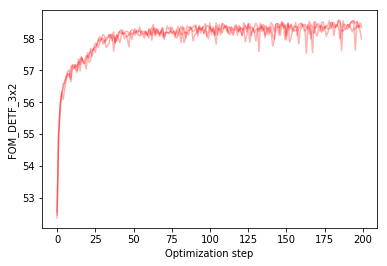

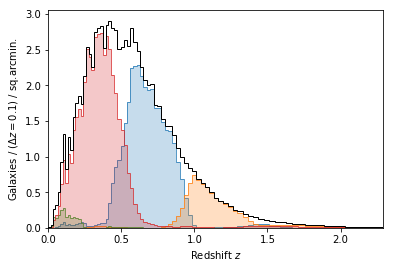

Starting job at 2020-09-11 16:25:11.594653 with {'nbin': 6, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 4, 'nepoch': 200, 'eta': 0.001, 'metric': 'FOM_DETF_3x2', 'seed': 1}
Trial 1/3 epoch 1/200 train 62.604 (max 62.604) validation 62.914.
Trial 1/3 epoch 11/200 train 71.628 (max 71.628) validation 71.563.
Trial 1/3 epoch 21/200 train 71.917 (max 72.027) validation 71.787.
Trial 1/3 epoch 31/200 train 72.587 (max 72.587) validation 72.322.
Trial 1/3 epoch 41/200 train 73.090 (max 73.090) validation 73.029.
Trial 1/3 epoch 51/200 train 73.247 (max 73.337) validation 73.293.
Trial 1/3 epoch 61/200 train 73.081 (max 73.357) validation 73.089.
Trial 1/3 epoch 71/200 train 73.317 (max 73.459) validation 73.418.
Trial 1/3 epoch 81/200 train 73.596 (max 73.596) validation 73.661.
Trial 1/3 epoch 91/200 train 73.575 (max 73.668) validation 73.600.
Trial 1/3 epoch 101/200 train 73.526 (max 73.680) validation 73.341.
Trial 1/3 epoch 111/200 train 73.677 (max 73.83

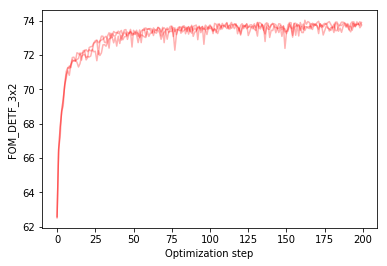

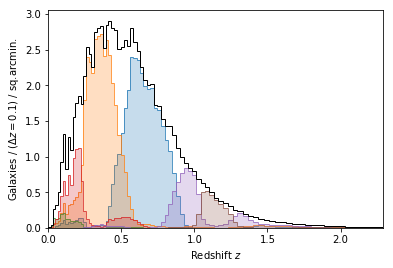

Starting job at 2020-09-11 16:33:43.687299 with {'nbin': 8, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 4, 'nepoch': 200, 'eta': 0.001, 'metric': 'FOM_DETF_3x2', 'seed': 1}
Trial 1/3 epoch 1/200 train 68.783 (max 68.783) validation 68.912.
Trial 1/3 epoch 11/200 train 83.427 (max 83.427) validation 83.512.
Trial 1/3 epoch 21/200 train 85.189 (max 85.189) validation 85.064.
Trial 1/3 epoch 31/200 train 86.329 (max 86.329) validation 86.381.
Trial 1/3 epoch 41/200 train 86.522 (max 86.639) validation 86.489.
Trial 1/3 epoch 51/200 train 86.695 (max 86.966) validation 86.640.
Trial 1/3 epoch 61/200 train 86.502 (max 86.966) validation 86.344.
Trial 1/3 epoch 71/200 train 86.845 (max 87.027) validation 86.917.
Trial 1/3 epoch 81/200 train 87.003 (max 87.153) validation 86.949.
Trial 1/3 epoch 91/200 train 86.652 (max 87.190) validation 86.505.
Trial 1/3 epoch 101/200 train 87.128 (max 87.282) validation 87.044.
Trial 1/3 epoch 111/200 train 87.218 (max 87.30

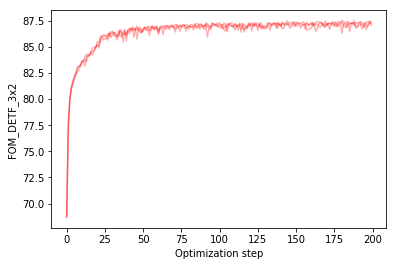

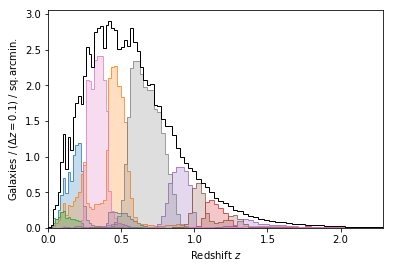

Starting job at 2020-09-11 16:44:08.125104 with {'nbin': 10, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 4, 'nepoch': 200, 'eta': 0.001, 'metric': 'FOM_DETF_3x2', 'seed': 1}
Trial 1/3 epoch 1/200 train 71.514 (max 71.514) validation 71.779.
Trial 1/3 epoch 11/200 train 92.433 (max 92.433) validation 92.402.
Trial 1/3 epoch 21/200 train 93.489 (max 93.489) validation 93.416.
Trial 1/3 epoch 31/200 train 93.950 (max 94.722) validation 94.132.
Trial 1/3 epoch 41/200 train 95.078 (max 95.508) validation 95.016.
Trial 1/3 epoch 51/200 train 95.627 (max 95.782) validation 95.616.
Trial 1/3 epoch 61/200 train 95.951 (max 96.105) validation 95.992.
Trial 1/3 epoch 71/200 train 96.072 (max 96.261) validation 96.070.
Trial 1/3 epoch 81/200 train 96.501 (max 96.722) validation 96.380.
Trial 1/3 epoch 91/200 train 96.484 (max 96.722) validation 96.426.
Trial 1/3 epoch 101/200 train 96.978 (max 96.978) validation 96.903.
Trial 1/3 epoch 111/200 train 96.773 (max 97.1

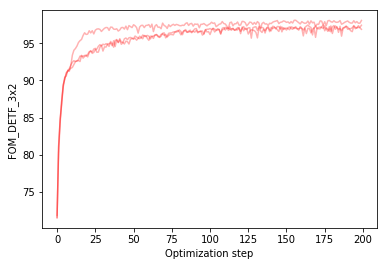

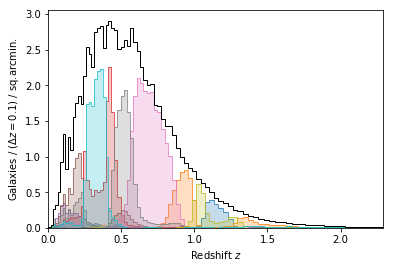

In [14]:
run_study('results/nn-4-64-detf', learn_nnet)

Starting job at 2020-09-11 17:00:48.616372 with {'nbin': 2, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 2, 'nepoch': 100, 'eta': 0.001, 'metric': 'FOM_DETF_3x2', 'seed': 1}
Trial 1/3 epoch 1/100 train 16.903 (max 16.903) validation 16.828.
Trial 1/3 epoch 11/100 train 19.442 (max 19.442) validation 19.411.
Trial 1/3 epoch 21/100 train 20.577 (max 20.577) validation 20.542.
Trial 1/3 epoch 31/100 train 20.600 (max 20.632) validation 20.564.
Trial 1/3 epoch 41/100 train 20.665 (max 20.665) validation 20.634.
Trial 1/3 epoch 51/100 train 20.695 (max 20.695) validation 20.670.
Trial 1/3 epoch 61/100 train 20.695 (max 20.710) validation 20.667.
Trial 1/3 epoch 71/100 train 20.709 (max 20.710) validation 20.674.
Trial 1/3 epoch 81/100 train 20.686 (max 20.722) validation 20.668.
Trial 1/3 epoch 91/100 train 20.702 (max 20.729) validation 20.679.
Trial 2/3 epoch 1/100 train 16.905 (max 20.731) validation 16.833.
Trial 2/3 epoch 11/100 train 19.618 (max 20.731) 

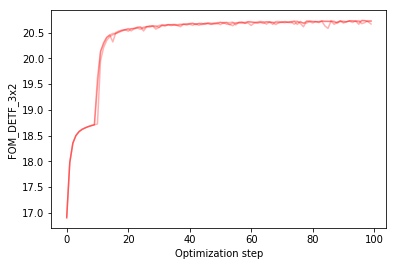

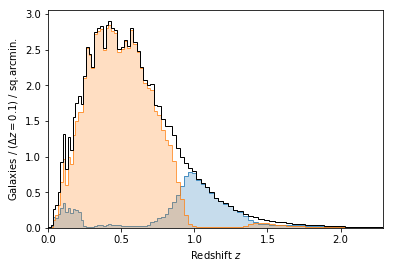

Starting job at 2020-09-11 17:02:29.794466 with {'nbin': 4, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 2, 'nepoch': 100, 'eta': 0.001, 'metric': 'FOM_DETF_3x2', 'seed': 1}
Trial 1/3 epoch 1/100 train 46.166 (max 46.166) validation 46.230.
Trial 1/3 epoch 11/100 train 55.865 (max 55.865) validation 56.004.
Trial 1/3 epoch 21/100 train 56.532 (max 56.783) validation 56.725.
Trial 1/3 epoch 31/100 train 57.014 (max 57.060) validation 57.045.
Trial 1/3 epoch 41/100 train 56.965 (max 57.188) validation 57.040.
Trial 1/3 epoch 51/100 train 57.244 (max 57.244) validation 57.288.
Trial 1/3 epoch 61/100 train 57.233 (max 57.387) validation 57.242.
Trial 1/3 epoch 71/100 train 57.580 (max 57.580) validation 57.487.
Trial 1/3 epoch 81/100 train 57.931 (max 57.931) validation 57.897.
Trial 1/3 epoch 91/100 train 57.974 (max 57.974) validation 57.948.
Trial 2/3 epoch 1/100 train 46.149 (max 58.062) validation 46.207.
Trial 2/3 epoch 11/100 train 55.798 (max 58.062) 

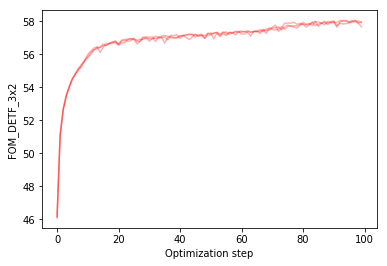

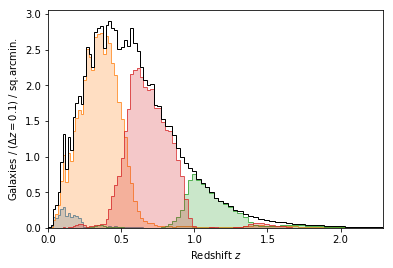

Starting job at 2020-09-11 17:04:37.280846 with {'nbin': 6, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 2, 'nepoch': 100, 'eta': 0.001, 'metric': 'FOM_DETF_3x2', 'seed': 1}
Trial 1/3 epoch 1/100 train 57.500 (max 57.500) validation 57.634.
Trial 1/3 epoch 11/100 train 70.495 (max 70.495) validation 70.492.
Trial 1/3 epoch 21/100 train 71.524 (max 71.543) validation 71.580.
Trial 1/3 epoch 31/100 train 72.167 (max 72.167) validation 72.106.
Trial 1/3 epoch 41/100 train 73.214 (max 73.214) validation 73.143.
Trial 1/3 epoch 51/100 train 73.522 (max 73.522) validation 73.458.
Trial 1/3 epoch 61/100 train 73.288 (max 73.543) validation 73.245.
Trial 1/3 epoch 71/100 train 73.747 (max 73.747) validation 73.623.
Trial 1/3 epoch 81/100 train 73.756 (max 73.799) validation 73.698.
Trial 1/3 epoch 91/100 train 73.859 (max 73.859) validation 73.791.
Trial 2/3 epoch 1/100 train 57.631 (max 73.891) validation 57.762.
Trial 2/3 epoch 11/100 train 70.689 (max 73.891) 

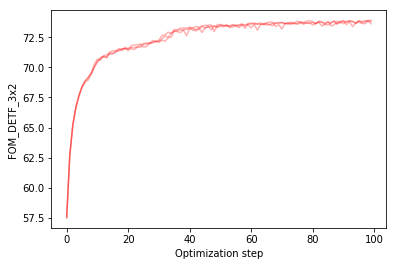

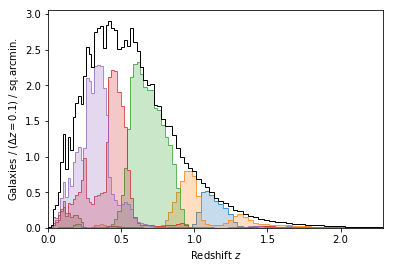

Starting job at 2020-09-11 17:08:28.532964 with {'nbin': 8, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 2, 'nepoch': 100, 'eta': 0.001, 'metric': 'FOM_DETF_3x2', 'seed': 1}
Trial 1/3 epoch 1/100 train 59.082 (max 59.082) validation 59.442.
Trial 1/3 epoch 11/100 train 81.649 (max 81.649) validation 81.799.
Trial 1/3 epoch 21/100 train 82.735 (max 82.763) validation 82.814.
Trial 1/3 epoch 31/100 train 83.193 (max 83.193) validation 83.249.
Trial 1/3 epoch 41/100 train 83.056 (max 83.320) validation 83.266.
Trial 1/3 epoch 51/100 train 83.544 (max 83.605) validation 83.678.
Trial 1/3 epoch 61/100 train 83.820 (max 83.898) validation 83.981.
Trial 1/3 epoch 71/100 train 84.063 (max 84.090) validation 84.215.
Trial 1/3 epoch 81/100 train 84.097 (max 84.362) validation 84.287.
Trial 1/3 epoch 91/100 train 85.305 (max 85.305) validation 85.215.
Trial 2/3 epoch 1/100 train 59.541 (max 85.637) validation 59.891.
Trial 2/3 epoch 11/100 train 81.547 (max 85.637) 

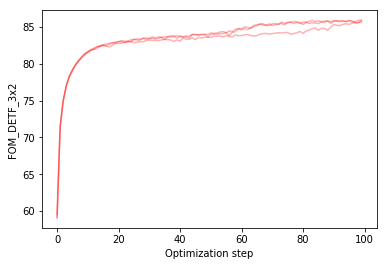

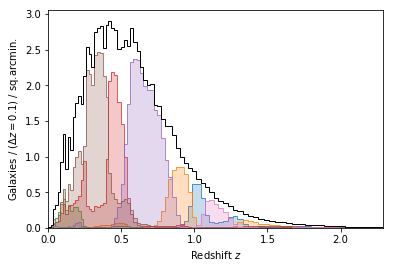

Starting job at 2020-09-11 17:13:15.111614 with {'nbin': 10, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 2, 'nepoch': 100, 'eta': 0.001, 'metric': 'FOM_DETF_3x2', 'seed': 1}
Trial 1/3 epoch 1/100 train 64.130 (max 64.130) validation 64.622.
Trial 1/3 epoch 11/100 train 90.203 (max 90.203) validation 90.285.
Trial 1/3 epoch 21/100 train 91.876 (max 92.064) validation 91.939.
Trial 1/3 epoch 31/100 train 92.919 (max 92.919) validation 92.873.
Trial 1/3 epoch 41/100 train 93.623 (max 93.623) validation 93.637.
Trial 1/3 epoch 51/100 train 93.968 (max 93.968) validation 93.962.
Trial 1/3 epoch 61/100 train 94.113 (max 94.182) validation 94.072.
Trial 1/3 epoch 71/100 train 94.229 (max 94.308) validation 94.221.
Trial 1/3 epoch 81/100 train 94.263 (max 94.390) validation 94.265.
Trial 1/3 epoch 91/100 train 94.402 (max 94.485) validation 94.359.
Trial 2/3 epoch 1/100 train 64.379 (max 94.538) validation 64.862.
Trial 2/3 epoch 11/100 train 90.224 (max 94.538)

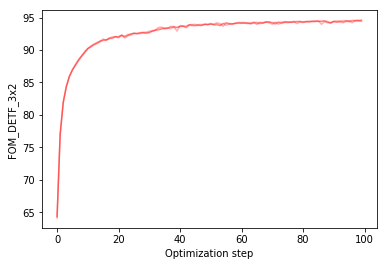

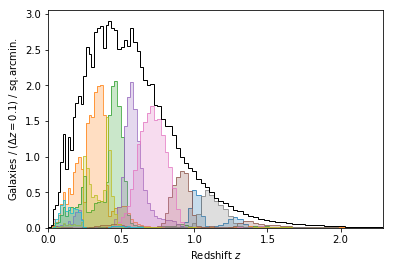

In [15]:
run_study('results/nn-2-64-detf', learn_nnet)